<a href="https://colab.research.google.com/github/MarkusThill/techdays25/blob/feature-lab2-initial-draft/notebooks/lab2-model-quantization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 🚀 Lab 2: Effiziente Quantisierung tiefer neuronaler Netze
- Dieses Jupyter Notebook **benötigt eine GPU Laufzeit**. Falls nicht bereits voreingestellt, kann daher der Laufzeittyp im Menü unter "Laufzeit" > "Laufzeittyp ändern" > "Hardwarebeschleuniger" > **"T4 GPU"** geändert werden!

Strukturierung:
- Teil 1: Darstellung numerischer Datentypen
- Teil 2:
  - Quantisierung des einfachen Modells aus Lab 1: TODO: Visualize loss function for widget!
  - Diverse Betrachtungen auf dem quantisierten Modell (Genauigkeit, etc.)
  - Gotchas (Optional): Overflow/Underflow am Beispiel eines Average Pooling layers
  - Subnormal Numbers
  - ...
- Teil 3: Quantisierung eines DTMF Klassifikationsmodells
  - Illustration: Erzeugung einer DTMF Wählsequenz und Abspielen derselben
  - Laden eines vortrainierten DTMF-Klassifikationsmodells (ConvNet; Keras oder PyTorch)
  - Konvertierung nach ONNX
  - Quantisierung nach FP16
  - Messung der Inferenzzeiten (auch für verschiedene Batch-Sizes) und vergleich von FP32, FP16-Modell
  - Vergleich der Genauigkeit von FP16 und FP32 Modell (wie ändert sich die Fehlerrate)
  - Optional: Konvertierung nach FP8 und Wiederholung der obigen Schritte
  - Optional: Profiling der ONNX Modelle. Wo liegen die "Hotspots" des Modells?
  - Optional: Trainieren des Modells auf de


# Vorbereitungen: Installation der nötigen Abhängigkeiten

In [1]:
# Remove the `%%capture`, if you have the impression that something is going wrong during the setup
#%%capture
!pip install "techdays25[lab2] @ git+https://github.com/MarkusThill/techdays25.git@feature-lab2-initial-draft"

  Cloning https://github.com/MarkusThill/techdays25.git (to revision feature-lab2-initial-draft) to /tmp/pip-install-h78e9mug/techdays25_02641d31f2de4a5b8f70b34bdbe1a6d2
  Running command git clone --filter=blob:none --quiet https://github.com/MarkusThill/techdays25.git /tmp/pip-install-h78e9mug/techdays25_02641d31f2de4a5b8f70b34bdbe1a6d2
  Running command git checkout -b feature-lab2-initial-draft --track origin/feature-lab2-initial-draft
  Switched to a new branch 'feature-lab2-initial-draft'
  Branch 'feature-lab2-initial-draft' set up to track remote branch 'feature-lab2-initial-draft' from 'origin'.
  Resolved https://github.com/MarkusThill/techdays25.git to commit a673a01602ec5bbbdb6d17832cee4f28c6fc1f4c
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.7/40.7 kB 4.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (se

**WICHTIG: Nach der Installation der Abhängigkeiten (siehe oben) muss die Google Colab Laufzeit neugestartet werden! Im Anschluss kann mit der Ausführung der nächsten Zellen fortgefahren werden werden.**

In [ ]:
!git clone "https://github.com/MarkusThill/techdays25.git"
!cd techdays25 && git checkout feature-lab2-initial-draft

In [ ]:
# @title Colab-spezifische Konfigurationen {display-mode: "form"}
import sys

IN_COLAB = "google.colab" in sys.modules

if IN_COLAB:
    from google.colab import output

    output.enable_custom_widget_manager()

# 📘 Einleitung und Gliederung

Dieses Jupyter Notebook ist in 4 Teile gegliedert. Es empfiehlt sich, die einzelnen Teile von vorne beginnend, nacheinander durchzuarbeiten.

- 📖 Teil 1: Darstellung numerischer Datentypen
  - In diesem Teil wiederholen wir verschiedene Darstellungen von numerischen Datentypen und lernen in einem interaktivem Modul die Unterschiede zwischen diesen kennen.
- 🔢 Teil 2: Quantisierung eines linearen Regressionsmodells (aus Lab 1)
- 🕸 Teil 3: Gotchas bei der Modellquantisierung am Beispiel eines einfachen Modells
- 📞 Teil 4: Quantisierung eines DTMF Klassifikationsmodells

# 📖 Teil 1: Darstellung numerischer Datentypen
- Zweierkomplementdarstellung
- IEEE-754 Standard

### Ganzahldarstellungen/Zweierkomplementdarstellung

In [ ]:
# @title Darstellung von 8-Bit Integer Zahlen {display-mode: "form"}

import ipywidgets as widgets
from IPython.display import HTML, display

# Initialize 8 toggle buttons (bits, MSB to LSB)
bit_toggles = [
    widgets.ToggleButton(
        value=False, description="0", layout=widgets.Layout(width="40px")
    )
    for _ in range(8)
]

# Color bars for sign and integer part
color_bars = [
    widgets.HTML(
        value='<div style="width: 40px; height: 10px; background-color: red;"></div>'
    )
    if i == 0
    else widgets.HTML(
        value='<div style="width: 40px; height: 10px; background-color: green;"></div>'
    )
    for i in range(8)
]

# Output widget to show results
output = widgets.Output()


def twos_complement(bits: list[int]) -> int:
    """Convert list of bits to signed integer using two's complement.

    Args:
        bits (list[int]): A list of bits representing the binary number.

    Returns:
        int: The signed integer value of the binary number.
    """
    if bits[0] == 0:
        return int("".join(str(b) for b in bits), 2)
    # If MSB is 1, it's negative
    inverted_bits = [1 - b for b in bits]  # Flip bits
    incremented = int("".join(str(b) for b in inverted_bits), 2) + 1
    return -incremented


def update_display(*args) -> None:
    """Update the display with the current binary, decimal, and hexadecimal values."""
    # Read bit values (MSB to LSB)
    bit_values = [int(btn.value) for btn in bit_toggles]
    bit_string = "".join(str(b) for b in bit_values)

    # Unsigned decimal value
    unsigned_decimal = int(bit_string, 2)

    # Signed decimal value (two's complement)
    signed_decimal = twos_complement(bit_values)

    # Hex representation (2 hex digits for 8 bits)
    hex_value = hex(unsigned_decimal).upper().replace("X", "x").replace("0X", "0x")

    # Clear previous output and update
    output.clear_output()
    with output:
        display(
            HTML(f"""
        <h3>
            Binärdarstellung: <code>
                <span style="color: red;">{bit_string[0]}</span>
                <span style="color: green;">{bit_string[1:]}</span>
            </code><br>
            Vorzeichenlose Dezimalzahl: <b>{unsigned_decimal}</b><br>
            Vorzeichenbehaftete Dezimalzahl (Zweierkomplement): <b>{signed_decimal}</b><br>
            Hexadezimaldarstellung: <b>{hex_value}</b>
        </h3>
        """)
        )

    # Update button labels (0/1)
    for btn, value in zip(bit_toggles, bit_values):
        btn.description = str(value)


# Attach observer to all buttons
for btn in bit_toggles:
    btn.observe(update_display, "value")

# Display widget
display(widgets.VBox([widgets.HBox(bit_toggles), widgets.HBox(color_bars)]))
display(output)

# Initialize display
update_display()


#### Übungsfragen (Optional):

- Was ist die größtmögliche bzw. kleinstmögliche Zahl die mit 8 Bit dargestellt werden können? Antwort: -128, +127

- Signed vs. Unsigned Darstellung: Setze das 8. Bit (höchstwertiges Bit) auf 1 und alle anderen Bits auf 0. Was sind die dezimalen Darstellungen dieser Zahl im signed und unsigned Format?
Erwartete Antwort: Signed: -128, Unsigned: 128

- Was charakterisiert eine negative Zahl in der Zweierkomplementdarstellung (unsigned integer) im Allgmeinen? Antwort: Zumindest das vorderste Bit ist gesetzt.

- Wie negiere ich eine Zahl (z.B. 32 -> -32 bzw. -71 -> 71)? Antwort: Invertieren aller Bits und Addition  von 1

- Angenommen ich habe -33 als 8-bit Zahl vorliegen. Wie würde ich daraus eine 32-bit unsigned Integer Zahl machen? Antwort: Einfach noch drei Bytes voranhängen in denen alle Bits gesetzt sind.

- Negative Zahlen in der Signed-Darstellung: Setze das 8. Bit (höchstwertiges Bit) und das 1. Bit (niederwertigstes Bit) auf 1 und alle anderen Bits auf 0. Was sind die dezimalen Darstellungen dieser Zahl im signed und unsigned Format?
Erwartete Antwort: Signed: -127, Unsigned: 129

- Maximale und minimale Werte: Was ist der maximale Wert, den man mit einer 8-Bit unsigned Zahl darstellen kann? Was ist der minimale Wert, den man mit einer 8-Bit signed Zahl darstellen kann?
Erwartete Antwort: Maximale unsigned: 255, Minimale signed: -128

- Alle Bits gesetzt: Setze alle Bits einer 8-Bit-Zahl auf 1. Was sind die dezimalen Darstellungen dieser Zahl im signed und unsigned Format?
Erwartete Antwort: Signed: -1, Unsigned: 255

### Fixkommadarstellungen

In [ ]:
# @title Darstellung von 16-Bit Integer/Festkomma-Zahlen {display-mode: "form"}
import ipywidgets as widgets
from IPython.display import HTML, display

# Initialize 16 toggle buttons (bits, MSB to LSB)
bit_toggles = [
    widgets.ToggleButton(
        value=False, description="0", layout=widgets.Layout(width="30px")
    )
    for _ in range(16)
]

# Color bars for sign, integer part, and fractional part
color_bars = [
    widgets.HTML(
        value='<div style="width: 30px; height: 10px; background-color: red;"></div>'
    )
    if i == 0
    else widgets.HTML(
        value='<div style="width: 30px; height: 10px; background-color: green;"></div>'
    )
    if 1 <= i <= 7
    else widgets.HTML(
        value='<div style="width: 30px; height: 10px; background-color: blue;"></div>'
    )
    for i in range(16)
]

# Output widget to show results
output = widgets.Output()

def twos_complement(bits: list[int]) -> int:
    """Convert list of bits to signed integer using two's complement.

    Args:
        bits (list[int]): A list of bits representing the binary number.

    Returns:
        int: The signed integer value of the binary number.
    """
    if bits[0] == 0:
        return int("".join(str(b) for b in bits), 2)
    # If MSB is 1, it's negative
    inverted_bits = [1 - b for b in bits]  # Flip bits
    incremented = int("".join(str(b) for b in inverted_bits), 2) + 1
    return -incremented

def fixed_point_value(bits: list[int]) -> float:
    """Convert a list of bits to a fixed-point value.

    Args:
        bits (list[int]): A list of 16 bits representing the binary number in fixed-point format.

    Returns:
        float: The fixed-point value of the binary number.
    """
    integer_part = bits[:8]
    fractional_part = bits[8:]

    # Calculate integer value
    integer_value = twos_complement(integer_part)

    # Calculate fractional value
    fractional_value = sum(
        bit * 2 ** (-i) for i, bit in enumerate(fractional_part, start=1)
    )

    return integer_value + fractional_value

def unsigned_fixed_point_value(bits: list[int]) -> float:
    """Convert a list of bits to an unsigned fixed-point value.

    Args:
        bits (list[int]): A list of 16 bits representing the binary number in fixed-point format.

    Returns:
        float: The unsigned fixed-point value of the binary number.
    """
    integer_part = bits[:8]
    fractional_part = bits[8:]

    # Calculate integer value
    integer_value = int("".join(str(b) for b in integer_part), 2)

    # Calculate fractional value
    fractional_value = sum(
        bit * 2 ** (-i) for i, bit in enumerate(fractional_part, start=1)
    )

    return integer_value + fractional_value

def update_display(*args) -> None:
    """Update the display with the current binary, decimal, and hexadecimal values."""
    # Read bit values (MSB to LSB)
    bit_values = [int(btn.value) for btn in bit_toggles]
    bit_string = "".join(str(b) for b in bit_values)

    # Unsigned decimal value
    unsigned_decimal = int(bit_string, 2)

    # Signed decimal value (two's complement)
    signed_decimal = twos_complement(bit_values)

    # Fixed-point value
    fixed_point_decimal = fixed_point_value(bit_values)

    # Unsigned fixed-point value
    unsigned_fixed_point_decimal = unsigned_fixed_point_value(bit_values)

    # Hex representation (4 hex digits for 16 bits)
    hex_value = hex(unsigned_decimal).upper().replace("X", "x").replace("0X", "0x")

    # Clear previous output and update
    output.clear_output()
    with output:
        display(
            HTML(f"""
        <h3>
            Binärdarstellung: <code>
                <span style="color: red;">{bit_string[0]}</span>
                <span style="color: green;">{bit_string[1:8]}</span>.
                <span style="color: blue;">{bit_string[8:]}</span>
            </code><br>
            Vorzeichenlose Dezimalzahl: <b>{unsigned_decimal}</b><br>
            Vorzeichenbehaftete Dezimalzahl (Zweierkomplement): <b>{signed_decimal}</b><br>
            Vorzeichenlose Festkommazahl: <b>{unsigned_fixed_point_decimal}</b><br>
            Vorzeichenbehaftete Festkommazahl (Zweierkomplement): <b>{fixed_point_decimal}</b><br>
            Hexadezimaldarstellung: <b>{hex_value}</b>
        </h3>
        """)
        )

    # Update button labels (0/1)
    for btn, value in zip(bit_toggles, bit_values):
        btn.description = str(value)

def reset_bits(*args) -> None:
    """Reset all toggle buttons to their initial state (False)."""
    for btn in bit_toggles:
        btn.value = False

# Create reset button
reset_button = widgets.Button(description="Reset", layout=widgets.Layout(width="100px"))
reset_button.on_click(reset_bits)

# Attach observer to all buttons
for btn in bit_toggles:
    btn.observe(update_display, "value")

# Display widget
display(widgets.VBox([widgets.HBox(bit_toggles), widgets.HBox(color_bars), reset_button]))
display(output)

# Initialize display
update_display()


#### Übungsfragen (Optional):
- Was ist die kleinstmögliche vorzeichenbehaftete Festkommazahl?
- Wie stelle ich -1.25 als Festkommazahl dar?
- Was ist die kleinstmögliche (größtmögliche) Festkommazahl größer (kleiner) als Null?

### Fließkommadarstellungen nach IEEE-754
- TODO: Subnormal Numbers
- Webseite mit noch mehr Darstellungen: https://evanw.github.io/float-toy/
- Verschiedene FP8-Darstellungen: https://asawicki.info/articles/fp8_tables.php
- https://onnx.ai/onnx/technical/float8.html

In [ ]:
# @title Darstellung von 16-Bit (FP16) Fließkomma-Zahlen {display-mode: "form"}

import struct
import ipywidgets as widgets
import numpy as np
from IPython.display import HTML, display

# Initialize 16 toggle buttons (bits)
bit_toggles = [
    widgets.ToggleButton(
        value=False, description="0", layout=widgets.Layout(width="30px")
    )
    for _ in range(16)
]

# Color bars for sign, exponent, and mantissa
color_bars = [
    widgets.HTML(
        value='<div style="width: 30px; height: 10px; background-color: red;"></div>'
    )
    if i == 0
    else widgets.HTML(
        value='<div style="width: 30px; height: 10px; background-color: green;"></div>'
    )
    if 1 <= i <= 5
    else widgets.HTML(
        value='<div style="width: 30px; height: 10px; background-color: blue;"></div>'
    )
    for i in range(16)
]

# Output widget to show FP16 value and components
output = widgets.Output()

def bits_to_float16(bits: list[int]) -> np.float16:
    """Convert list of bits to FP16 float value.

    Args:
        bits (list[int]): A list of bits representing the binary number.

    Returns:
        np.float16: The FP16 float value of the binary number.
    """
    bit_string = "".join(str(b) for b in bits)
    # Convert binary string to integer
    int_value = int(bit_string, 2)
    # Pack as unsigned 16-bit int, then unpack as float16 using numpy
    packed = struct.pack("<H", int_value)  # Big endian 16-bit unsigned int
    return np.frombuffer(packed, dtype=np.float16)[0]

def update_display(*args):
    """Update the display with the current binary, FP16 float value, and its components."""
    # Read bit values (MSB to LSB)
    bit_values = [int(btn.value) for btn in bit_toggles]
    bit_string = "".join(str(b) for b in bit_values)

    # Extract components
    sign = bit_values[0]
    exponent_bits = bit_values[1:6]
    mantissa_bits = bit_values[6:]

    exponent = int("".join(str(b) for b in exponent_bits), 2)
    exponent_unbiased = exponent - 15  # Bias = 15

    mantissa_raw = "".join(str(b) for b in mantissa_bits)
    mantissa_value = (
        1 + sum(int(b) * 2 ** (-i) for i, b in enumerate(mantissa_bits, start=1))
        if exponent != 0
        else 0
    )

    # Convert to float16 value
    fp16_value = bits_to_float16(bit_values)

    # Clear previous output and display new info
    output.clear_output()
    with output:
        display(
            HTML(f"""
        <h3>
            Binärdarstellung: <code>
                <span style="color: red;">{bit_string[0]}</span>
                <span style="color: green;">{bit_string[1:6]}</span>
                <span style="color: blue;">{bit_string[6:]}</span>
            </code><br>
            Vorzeichen (1 bit): <b>{sign}</b> ({"-" if sign else "+"})<br>
            Exponent (5 bits): <b>{"".join(str(b) for b in exponent_bits)} (biased: {exponent}, unbiased: {exponent_unbiased})</b><br>
            Mantisse (10 bits): <b>{mantissa_raw}</b><br>
            <hr>
            <b>FP16 Dezimaldarstellung: {fp16_value} </b>
        </h3>
        """)
        )

    # Update button labels
    for btn, value in zip(bit_toggles, bit_values):
        btn.description = str(value)

def reset_bits(*args) -> None:
    """Reset all toggle buttons to their initial state (False)."""
    for btn in bit_toggles:
        btn.value = False

# Create reset button
reset_button = widgets.Button(description="Reset", layout=widgets.Layout(width="100px"))
reset_button.on_click(reset_bits)

# Attach observer to all buttons
for btn in bit_toggles:
    btn.observe(update_display, "value")

# Display widget
display(widgets.VBox([widgets.HBox(bit_toggles), widgets.HBox(color_bars), reset_button]))
display(output)

# Initialize output
update_display()  # 0 01111 0000000001 ^=^ 1.00097656

#### Übungsfragen (Optional):
- Wie würde ich 1.0, 0.5 und 7.0 darstellen?
- Gibt es einen Unterschied zwischen +0.0 und -0.0?
- Wie stelle ich `+Inf` bzw. `-Inf` dar?
- Wie stelle ich `NaN` dar?
- Was ergibt der Vergleich `float("nan") != float("nan")`?

# 🔢 Teil 2: Quantisierung eines linearen Regressionsmodells (aus Lab 1)

TODO: Einleitung hier:

In [ ]:
# Load necessary libs
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import onnx
import pandas as pd
from onnxconverter_common import float16

from techdays25.onnx_utils import (
    OnnxModel,
    benchmark_models_on_batch_size,
    plot_benchmark_results,
)

In [ ]:
# Specify, which model to use:
onnx_model_path = Path("techdays25/assets/lab1/pytorch_regression.onnx")

In [ ]:
# Visualize the model again:

from techdays25 import onnx_utils
onnx_utils.netron_visualize(str(onnx_model_path))

## Quantisiere ONNX Modell nach FP16

In [ ]:


# Load the previously saved FP32 ONNX model
regression_model_fp32 = onnx.load(onnx_model_path)

# Convert the FP32 ONNX model to FP16 precision
# The keep_io_types=True argument ensures that the input and output types remain the same
onnx_model_fp16 = float16.convert_float_to_float16(
    regression_model_fp32,  # path to the onnx model
    min_positive_val=1e-7,  # Constant values will be clipped to these bounds
    max_finite_val=1e4,  # same as above
    keep_io_types=True,  # If set to false, the IO types will change to FP16
    disable_shape_infer=False,  # Skips running onnx shape/type inference
    op_block_list=None,  # A list of OPs which shall not be quantized
    node_block_list=None,  # A list of nodes which shall not be converted
)

# Define the path where the FP16 ONNX model will be saved
onnx_model_fp16_path = onnx_model_path.stem + "_fp16" + onnx_model_path.suffix

# Save the converted FP16 ONNX model to the specified path
onnx.save(onnx_model_fp16, onnx_model_fp16_path)

# Print a message indicating that the FP16 ONNX model has been saved successfully
print(f"ONNX model (FP16) saved to {onnx_model_fp16_path}")

## Quantisiere Modell nach INT8

In [ ]:
# Imports:
from typing import Any

import numpy as np
from onnxruntime.quantization import (
    CalibrationDataReader,
    QuantType,
    quantize_dynamic,
    quantize_static,
)
from onnxruntime.quantization.shape_inference import quant_pre_process

In [ ]:
# First try static quantization and then switch to dynamic quantization
# and see how the results change
static_quantization = True  # toggles between static and dynamic quantization
onnx_model_path_int8 = onnx_model_path.stem + "_int8.onnx"

quant_pre_process(onnx_model_path, onnx_model_path_int8 + ".pre")


class CalibrationDataReaderImpl(CalibrationDataReader):
    """A class for constructing calibration data for the ONNX INT8 calibration."""

    def __init__(self) -> None:
        """Initialize the CalibrationDataReaderImpl.

        This class implements a calibration data reader for INT8 calibration.
        It generates synthetic data for calibration purposes.
        """
        self.counter: int = 0

    def get_next(self) -> dict[str, Any] | None:
        """Get the next batch of calibration data.

        This method generates synthetic data for calibration. It returns None after 16 batches.

        Returns:
            Optional[Dict[str, Any]]: A dictionary containing the input data for calibration,
            or None if there are no more batches.
        """
        if self.counter >= 16:
            return None
        self.counter += 1
        X = np.linspace(-10, 10, 1000).reshape(-1, 1)
        return {"input": X.astype(np.float32)}


# Prepare calibration data
calibration_data_reader = CalibrationDataReaderImpl()

if static_quantization:
    quantize_static(
        onnx_model_path_int8 + ".pre",
        onnx_model_path_int8,
        calibration_data_reader,
        # quant_format=QuantFormat.QOperator,
        per_channel=True,
        weight_type=QuantType.QInt8,
    )
else:
    quantize_dynamic(
        onnx_model_path_int8 + ".pre",
        onnx_model_path_int8,
        weight_type=QuantType.QInt8,  # Quantize weights to int8
        per_channel=True,  # Enable per-channel quantization
        reduce_range=True,  # Reduce the quantization range
    )

## Netron Visualisierung der ONNX Modelle

In [ ]:
from techdays25 import onnx_utils

# Change model path accordingly:
onnx_utils.netron_visualize("pytorch_regression_int8.onnx")

## Vergleich der quantisierten Modellvarianten mit ursprünglichem Modell

In [ ]:
reg_model_fp32_cpu = OnnxModel(onnx_model_path, provider="CPUExecutionProvider")
reg_model_fp16_cpu = OnnxModel(onnx_model_fp16_path, provider="CPUExecutionProvider")
reg_model_int8_cpu = OnnxModel(onnx_model_path_int8, provider="CPUExecutionProvider")

reg_model_fp32_gpu = OnnxModel(onnx_model_path, provider="CUDAExecutionProvider")
reg_model_fp16_gpu = OnnxModel(onnx_model_fp16_path, provider="CUDAExecutionProvider")
reg_model_int8_gpu = OnnxModel(onnx_model_path_int8, provider="CUDAExecutionProvider")

print("\nSpezifikation des FP16 Modells:")
print(reg_model_fp16_cpu)

In [ ]:
# Create some random data and compare the results of the FP16 and FP32 models
u_range = (-10, 10)  # set range for which input values shall be generated

models = {
    "FP32/CPU": reg_model_fp32_cpu,  # first model is the reference
    "FP16/CPU": reg_model_fp16_cpu,
    #"INT8/CPU": reg_model_int8_cpu,
    # "FP32/GPU": reg_model_fp32_gpu,
    "FP16/GPU": reg_model_fp16_gpu,
    "INT8/GPU": reg_model_int8_gpu,
}

uu = np.linspace(*u_range, 15).reshape(-1, 1).astype(np.float32)
ii_predictions = {k: m.predict(uu).flatten() for k, m in models.items()}

# Extract the first key-value pair (this is the reference)
first_key = next(iter(ii_predictions))
first_value = ii_predictions[first_key]
ii_diffs = {
    "Δ" + k: first_value - v for k, v in ii_predictions.items() if k != first_key
}

df_data = {"Input [U/V]": uu.flatten()}

df_data.update(ii_predictions)
df_data.update(ii_diffs)

pd.DataFrame(df_data)

### Fragen (Optional)
- Wie verhalten sich die Modellausgaben/Differenzen der beiden obigen Modelle für unterschiedliche Bereiche, die in `u_range` spezifiziert werden, z.B. für `u_range=(0,100)` oder `u_range=(-1000, 1000)`?
- Wie lassen sich mögliche Abweichungen erklären?

In [ ]:
# Comment/Uncomment the lines in `models` to unselect/select certain models
models = {
    "FP32/CPU": reg_model_fp32_cpu,  # first model is the reference
    #"FP16/CPU": reg_model_fp16_cpu,
    #"INT8/CPU": reg_model_int8_cpu,
    # "FP32/GPU": reg_model_fp32_gpu,
    "FP16/GPU": reg_model_fp16_gpu,
    "INT8/GPU": reg_model_int8_gpu,
}

# systematically evaluate the model differences for a given range
uu = np.linspace(-200, 200, 100000).reshape(-1, 1).astype(np.float32)

ii_predictions = {k: m.predict(uu).flatten() for k, m in models.items()}
# Extract the first key-value pair (this is the reference)
ref_key = next(iter(ii_predictions))
ref_value = ii_predictions[ref_key]
ii_diffs = {k: ref_value - v for k, v in ii_predictions.items() if k != ref_key}

plt.figure(figsize=(10, 5))
for k, v in ii_diffs.items():
    plt.plot(uu, v, label=k)

# plt.yscale("symlog", linthresh=.0001)
plt.grid(which="both")
plt.xlabel("U [V]")
plt.ylabel(r"$\Delta \hat{I}_{ref}$ [mA]")
plt.legend()
plt.title(f"Abweichungen diverser ONNX Modelle zur Referenz {first_key}")
plt.show()

### Fragen (Optional)
- Unterscheiden sich die Kurven für INT8/CPU (FP16/CPU) und INT8/GPU (FP16/GPU)? Wieso?
- Wie ist das Verhalten der Kurven für die INT8-Modelle (statisch quantisiert) bei $\pm 10.0$ zu erklären?
- Gibt es Unterschiede zwischen den statisch und dynamische quantisierten INT8 Modellen?


## Messung der Inferenzzeiten für die quantisierten Modelle
- Wir variieren die Batch-Size und messen die Laufzeit für jeweils $n$ Durchläufe

In [ ]:
# measure inference times/latency for different batch sizes

batch_sizes = [2**i for i in range(10, 23)]
model_dict = {
    "ONNX Regression Model (FP32/CPU)": reg_model_fp32_cpu.predict,
    #"ONNX Regression Model (FP16/CPU)": reg_model_fp16_cpu.predict,
    #"ONNX Regression Model (INT8/CPU)": reg_model_int8_cpu.predict,
    "ONNX Regression Model (FP32/GPU)": reg_model_fp32_gpu.predict,
    "ONNX Regression Model (FP16/GPU)": reg_model_fp16_gpu.predict,
    "ONNX Regression Model (INT8/GPU)": reg_model_int8_gpu.predict,
}

benchmark_results = benchmark_models_on_batch_size(
    model_dict=model_dict,
    input_shape=(1,),
    batch_sizes=batch_sizes,
    n_runs=100,
    verbose=True,
)

In [ ]:
plot_benchmark_results(results=benchmark_results, title="Laufzeiten der unterschiedlichen quantisierten Modelle", xscale="log", yscale=None)

### Fragen (Optional)
- Wie stark ist der Einfluss der Quantisierungen bei diesem Modell auf die Laufzeit?
- Wie ist das Laufzeitverhalten des statisch vs. dynamisch quantisierten Modells?

# 🕸 Teil 3: Gotchas bei der Modellquantisierung am Beispiel eines einfachen Modells

In diesem Teil werden wir uns damit befassen, welche Probleme bei der Modellquantisierung auftreten können und dies anhand eines Beispiels illustrieren. Folgende Schritte werden durchgeführt:
- Erstellen eines benutzerdefinierten Modells in Keras zur Mittelwertbildung über entlang der Zeitachse.
- Konvertieren des Keras-Modells in das ONNX-Format.
- Quantisieren des ONNX-Modells von FP32 auf FP16.
- Generierung von 3-dimensionalen Zeitreihendaten für die Modellinferenz.
- Modellinferenz mit dem Keras-Modell.
- Modellinferenz mit den FP32/FP16 ONNX-Modellen:
  - Laden und Ausführen von ONNX-Modellen mit der ONNX Runtime.
  - Vergleich der Ausgaben von FP32- und FP16-ONNX-Modellen.
- Diskussion der Beobachtungen und möglicher Lösungen.


## Modelldefinition

Unser Modell unten nimmt einen 3-dimensionalen Eingabetensor mit den Dimensionen (Batch-Größe, Sequenzlänge, Merkmalsanzahl) entgegen. In unserem Beispiel hat der Eingabetensor die Form (2, 10000, 3), was bedeutet, dass wir zwei Batch-Elemente haben, jedes mit einer Sequenzlänge von 10000 und 3 Merkmalen pro Zeitschritt.

Nach der Verarbeitung durch das Modell wird die Zeitdimension reduziert, und die Ausgabe hat die Form (Batch-Größe, Merkmalsanzahl). Für unser Beispiel ergibt sich eine Ausgabe mit der Form (2, 3). Die Ausgabe repräsentiert den Durchschnitt der Merkmale über die gesamte Sequenzlänge für jedes Batch-Element.

**Beispiel (Visuelles Beispiel weiter unten)**

Eingabetensor (2 x 4 x 3):
```
[
  [
    [3, 4, 5],
    [4, 5, 6],
    [7, 8, 9],
    [10, 11, 12]
  ],
  [
    [2, 4, 6],
    [8, 10, 12],
    [14, 16, 18],
    [20, 22, 24]
  ]
]
```

Ausgabetensor (2 x 3):
```
[
  [ 6,  7,  8],
  [11, 13, 15]
]
```


In [ ]:
import tensorflow as tf
from tensorflow.keras import Model
from tensorflow.keras.layers import Input, Layer


class SumLayer(Layer):
    """Custom Layer to sum over time dimension of a tensor."""

    def call(self, inputs: tf.Tensor) -> tf.Tensor:
        """Reduce (sum) the input tensor along the time axis (axis=1).

        Args:
            inputs (tf.Tensor): The input tensor of shape (batch_size, sequence_length, feature_dim).

        Returns:
            tf.Tensor: The reduced tensor of shape (batch_size, feature_dim).
        """
        return tf.reduce_sum(inputs, axis=1)


# Custom Layer: Division by sequence length
class DivisionLayer(Layer):
    """Divide a tensor by the length of the given sequence."""

    def call(self, inputs: tuple[tf.Tensor, tf.Tensor]) -> tf.Tensor:
        """Divide the summed tensor by the sequence length to get the average.

        Args:
            inputs (Tuple[tf.Tensor, tf.Tensor]): A tuple containing the summed tensor and the original input tensor.
                - tensor_x (tf.Tensor): The summed tensor of shape (batch_size, feature_dim).
                - original_input (tf.Tensor): The original input tensor of shape (batch_size, sequence_length, feature_dim).

        Returns:
            tf.Tensor: The averaged tensor of shape (batch_size, feature_dim).
        """
        tensor_x, original_input = inputs
        seq_length = tf.shape(original_input)[
            1
        ]  # Get the dynamic sequence length (length of the time dimension)
        return tensor_x / tf.cast(seq_length, dtype=tensor_x.dtype)


# Define model with separate Sum and Division layers
def global_average_pooling_1d() -> Model:
    """Define a Keras model with separate Sum and Division layers for global average pooling.

    Returns:
        Model: A Keras model that performs global average pooling over the time dimension.
    """
    inputs = Input(
        shape=(None, 3), name="input"
    )  # Define the input layer with shape (sequence_length=None, feature_dim=3)
    sum_x = SumLayer(name="sum")(inputs)  # Apply the SumLayer to the inputs
    output = DivisionLayer(name="divide")([
        sum_x,
        inputs,
    ])  # Apply the DivisionLayer to the summed tensor and the original inputs
    return Model(
        inputs, output, name="GlobalAveragePooling1D"
    )  # Create the Keras model with the specified input and output


# Create the model
model = global_average_pooling_1d()

# Print model summary to see the architecture
model.summary()

## Beispiel

In [ ]:
# Generate sample data
batch_size = 2
sequence_length = 5
feature_dim = 3
np.random.seed(0)
sample_data = np.random.rand(batch_size, sequence_length, feature_dim).astype(np.float32).round(1)
print(f"Input {str(sample_data.shape).replace(',', ' x')}:\n", sample_data)

# Pass data through the model
output_data = model.predict(sample_data, verbose=0)

# Print the output
print(f"\nOutput {str(output_data.shape).replace(',', ' x')}:\n", output_data)

In [ ]:
# @title Visualisierung der obigen Beispieldaten {display-mode: "form"}

# Visualize the input and output
def plot_data(input_data, output_data):
    batch_size, sequence_length, feature_dim = input_data.shape
    gap_size = 1  # Size of the gap between rows and columns
    total_cols = sequence_length + 1 + gap_size  # Include gap for output column
    total_rows = feature_dim + gap_size  # Include gap between rows

    fig, axes = plt.subplots(nrows=batch_size, ncols=1, figsize=(9, 3 * batch_size))

    if batch_size == 1:
        axes = [axes]

    for i in range(batch_size):
        ax = axes[i]
        data_with_output = np.full((feature_dim, total_cols), np.nan)  # Initialize with NaNs for gaps
        data_with_output[:, :sequence_length] = input_data[i].T  # Fill input data (transpose to match dimensions)
        data_with_output[:, sequence_length + gap_size] = output_data[i]  # Fill output data

        cax = ax.matshow(data_with_output, cmap='Blues', vmin=0, vmax=1)

        for (j, k), val in np.ndenumerate(data_with_output):
            if not np.isnan(val):
                ax.text(k, j, f'{val:.2f}', ha='center', va='center', color='black')

        ax.set_xticks(np.arange(total_cols))
        ax.set_xticklabels([f'$t_{t}$' for t in range(sequence_length)] + [''] * gap_size + ['Modell-Output'])
        ax.set_yticks(np.arange(feature_dim))
        ax.set_yticklabels([f'Kanal {f}' for f in range(feature_dim)])
        ax.set_title(f'Signal {i+1}')

        # Remove tick lines and surrounding border
        ax.tick_params(axis='both', which='both', length=0)
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        ax.spines['bottom'].set_visible(False)
        ax.spines['left'].set_visible(False)

    plt.tight_layout()
    plt.show()

plot_data(sample_data, output_data)

## Modellkonvertierung nach ONNX

In [ ]:
# Convert our GlobalAveragePooling1D Model to ONNX format
import onnx  # ONNX library for handling ONNX models
import tf2onnx  # TensorFlow to ONNX conversion library
from onnxconverter_common import float16  # Utility for FP16 conversion

# Define the path where the FP32 ONNX model will be saved
onnx_model_path_fp32 = "gap1d_model_fp32.onnx"

# Convert the Keras model to ONNX format with FP32 precision
# Define the input specification for the model conversion
spec = (tf.TensorSpec((None, None, 3), tf.float32, name="input"),)
# Convert the Keras model to ONNX using tf2onnx
onnx_model, _ = tf2onnx.convert.from_keras(model, input_signature=spec, opset=18)

# Save the converted FP32 ONNX model to the specified path
onnx.save(onnx_model, onnx_model_path_fp32)
print(f"ONNX model (FP32) saved to {onnx_model_path_fp32}")

## Quantisierung des ONNX Modells

In [ ]:
# Now quantize the ONNX model to FP16 and save it

# Load the previously saved FP32 ONNX model
onnx_model_fp32 = onnx.load(onnx_model_path_fp32)

# Convert the FP32 ONNX model to FP16 precision
# The keep_io_types=True argument ensures that the input and output types remain the same
onnx_model_fp16 = float16.convert_float_to_float16(onnx_model_fp32, keep_io_types=True)

# Define the path where the FP16 ONNX model will be saved
onnx_model_path_fp16 = "gap1d_model_fp16.onnx"

# Save the converted FP16 ONNX model to the specified path
onnx.save(onnx_model_fp16, onnx_model_path_fp16)

# Print a message indicating that the FP16 ONNX model has been saved successfully
print(f"ONNX model (FP16) saved to {onnx_model_path_fp16}")

In [ ]:
from techdays25 import onnx_utils

onnx_utils.netron_visualize("gap1d_model_fp16.onnx")

## Datengenerierung

In [ ]:
# First create some data and put it through the Keras model
import matplotlib.pyplot as plt  # Library for plotting
import numpy as np  # Library for numerical operations

# Create a random input tensor with a batch size of 2
# Generate a sequence of numbers from 0 to 9999 and reshape it to (1, 10000, 1)
tt = np.arange(10_000).reshape(1, -1, 1)

# Create an offset array and reverse it
off = (np.array(np.arange(6)).astype(np.float32) + 4)[::-1]

# Generate a 3-dimensional time series data using a sine function with the offset
xx = 0.4 * np.sin(4 * np.pi * 1e-5 * off**2 * tt) + off

# Reshape the data to have dimensions (sequence_length, batch_size, feature_dim)
xx = xx.reshape(-1, 2, 3)

# Swap the axes to get the shape (batch_size, sequence_length, feature_dim)
xx = np.swapaxes(xx, 0, 1)

# Convert the data to float32 type
x_input = xx.astype(np.float32)

# Print the dimensions of the input tensor
print("Dimensions of the input tensor:", x_input.shape)

In [ ]:
# Plot the generated time series data
import matplotlib.pyplot as plt  # Library for plotting (re-imported for completeness)

# Create a new figure with a specified size
plt.figure(figsize=(10, 6))

# Plot the first batch (b$_1$) of the time series data
plt.plot(xx[0, :, :], label="b$_1$")

# Plot the second batch (b$_2$) of the time series data
plt.plot(xx[1, :, :], label="b$_2$")

# Set the label for the x-axis
plt.xlabel("t")

# Set the label for the y-axis
plt.ylabel("Amplitude")

# Set the title of the plot
plt.title("Ein Batch bestehend aus jeweils zwei 3-dimensionalen Zeitreihen")

# Add a legend to the plot
plt.legend(loc="upper center", bbox_to_anchor=(1.1, 0.6), ncol=2)

# Display the plot
plt.show()

## Inferenz mit dem Keras Modell

In [ ]:
# Put the data through the Keras model

# Use the Keras model to make predictions on the input data
y_output_keras = model.predict(x_input, verbose=0)

# Print the dimensions of the input tensor
print("Dimensionen des Eingabetensors:", str(x_input.shape).replace(',', " x"))  # Erwartete Form: (2, 10000, 3)

# Print the dimensions of the Keras model output
print(
    "Dimensionen der Keras-Modellausgabe:", str(y_output_keras.shape).replace(',', " x")
)  # expected shape: (2, 3) -> reduced time axis!

# Print the output of the Keras model
print("\nKeras-Modellausgabe:\n", y_output_keras)

## Inferenz mit den FP32/FP16 ONNX Modellen

In [ ]:
# Run the FP32 ONNX model
y_output_onnx_fp32 = OnnxModel(onnx_model_path="gap1d_model_fp32.onnx").predict(x_input)

# Print the output of the FP32 ONNX model
print("\nONNX (FP32) Modellausgabe:\n", y_output_onnx_fp32)

In [ ]:
# Run the FP16 ONNX model
y_output_onnx_fp16 = OnnxModel(onnx_model_path="gap1d_model_fp16.onnx").predict(x_input)

# Print the output of the FP32 ONNX model
print("\nONNX (FP16) Modellausgabe:\n", y_output_onnx_fp16)

## Fragen / Diskussion
- Welche Ergebnisse erwarten wir? Stimmen die Ergebnisse mit den Erwartungen überein?
- Was fällt bei der Ausgabe des quantisierten FP16 Modells auf?
  - Wie könnte man sich dieses Ergebnis erklären?
  - Lässt sich das Problem ggfs. vermeiden?


# 📞 Teil 4: Quantisierung eines DTMF Klassifikationsmodells

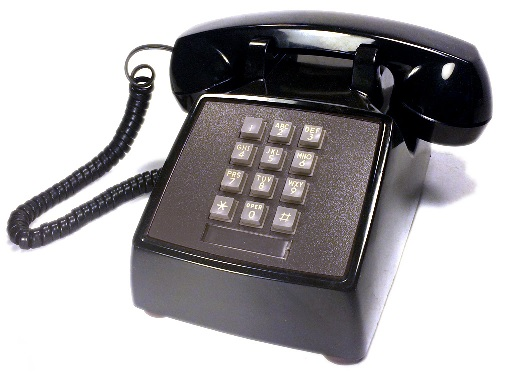

## Einführung: Generierung und Dekodierung/Klassifizierung von DTMF (dual-tone multi-frequency) Signalen <a class="anchor" id="part0"></a>


Das Dualton-Mehrfrequenzwahlverfahren (DTMF) ist ein Signalisierungssystem für das Wählen eines Telefons, das in den frühen 1960er Jahren von Western Electric entwickelt und später von Bell System kommerziell an Telefonkunden geliefert wurde.
Wenn eine Taste auf dem Telefon gedrückt wird, werden zwei harmonische Tonsignale erzeugt, und die Superposition/Überlagerung beider Signale wird verwendet, um die entsprechende Telefontaste zu charakterisieren. Wenn zum Beispiel die Taste „5“ gedrückt wird, entsteht ein Dualtontonsignal, das sich aus den Frequenzen 770 Hz und 1336 Hz zusammensetzt. Die beiden Frequenzen, die jede Taste beschreiben, sind in der folgenden Tabelle aufgeführt:

|   | 1209Hz  | 1336 Hz  | 1477 Hz   | 1633 Hz  |
|---|:---:|:---:|:---:|:---:|
| **697 Hz**  |  1 | 2  | 3  | A  |
| **770 Hz**  |  4 | 5  | 6  | B  |
| **852 Hz**  |  7 | 8  | 9  | C  |
| **941 Hz**  |  * | 0  | #  | D  |

In diesem Beispiel werden wir uns ansehen, wie man solche DTMF-Wählsequenzen generiert, sie in einer Audiodatei speichert und das Audiosignal mit einem einfachen KI-Modell wieder dekodiert.

Wir werden die folgenden Schritte durchführen, um ein DTMF-Signal zu erzeugen und mit einem Klassifikationsmodell zu dekodieren:
1. Erzeugung des Signals und der Audiodatei mit `scipy` und `numpy`. Wir speichern die erzeugte Audiodatei in einer `.wav` Datei, die in diesem Notebook oder in deinem lokalen Audioplayer abgespielt werden kann
2. Wir entwerfen eine einfaches KI-Modell ... TODO
3. Extraktion der gewählten Tastenfolge aus der `.wav`-Datei unter Verwendung des KI-Modells
4. Quantisierung & Export des Modells nach ONNX im FP32 und FP16 Format. Quantisierung nach INT8 und Export nach TensorRT.
5. Laufzeituntersuchungen für FP32/FP16/INT8, unterschiedliche Batch-Größen und Signallängen.

In [ ]:
# TODOs:
# Try to use ONNX INT8-model for TF
# Look at results of quantized INT8 ONNX model for DTMF
# QAT of Tensorflow -> tf2onnx -> ORT/TRT
# Hinweis Laufzeit neu starten in rot
# Profiling in ONNX/TRT
# ONNX INT8 Modell for DTMF
# Numerierung der Abschnitte
# Untersuche Abweichungen. Wie ändert sich die Fehlerrate des Modells für FP32/Fp16?
# Merge to master branch and change installation instructions in notebooks!
# Add DTMF model artifacts to assets folder
# ### TODO: Genauigkeit der einzelnen Modelle: Genaugigkeit auch für verschiedene Rauschlevel

## Signal- und Audiodatei-Generierung <a class="anchor" id="part1"></a>
- Im folgendem Widget ist es möglich, eine Nummer zu wählen, für die ein DTMF-Signal generiert werden soll
- Falls im Widget keine Nummer "gewählt" wird, wird eine Default-Sequenz angenommen

In [ ]:
# First import the necessary libs
import time

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
from scipy.io import wavfile

In [ ]:
# @title Tastenfeld-Widget für Generierung der Wählsequenz' {display-mode: "form"}

import ipywidgets as widgets

# from IPython.display import display

# Initialize a text widget to display the dial sequence
dial_sequence = widgets.Text(
    value="",
    placeholder="Dial sequence will appear here...",
    description="",
    disabled=True,
    layout=widgets.Layout(width="300px"),
)


# Function to handle button clicks
def on_button_click(b):
    """_summary_.

    Args:
        b (_type_): _description_
    """
    dial_sequence.value += b.description


# Create buttons for the phone dialer
buttons = []
for row in [
    ["1", "2", "3", "A"],
    ["4", "5", "6", "B"],
    ["7", "8", "9", "C"],
    ["*", "0", "#", "D"],
]:
    button_row = []
    for label in row:
        button = widgets.Button(
            description=label, layout=widgets.Layout(width="50px", height="50px")
        )
        button.on_click(on_button_click)
        button_row.append(button)
    buttons.append(widgets.HBox(button_row))

# Create a clear button
clear_button = widgets.Button(
    description="Clear", layout=widgets.Layout(width="158px", height="50px")
)

back_button = widgets.Button(
    description="⬅", layout=widgets.Layout(width="50px", height="50px")
)


def on_clear_click(b):
    """_summary_.

    Args:
        b (_type_): _description_
    """
    global dial_sequence
    dial_sequence.value = ""


def on_back_click(b):
    """_summary_.

    Args:
        b (_type_): _description_
    """
    global dial_sequence
    dial_sequence.value = dial_sequence.value[:-1]


clear_button.on_click(on_clear_click)


back_button.on_click(on_back_click)

# Display the dialer
display(dial_sequence)
for button_row in buttons:
    display(button_row)
display(widgets.HBox([clear_button, back_button]))

In [ ]:
print("Gewählte Sequenz:", dial_sequence.value)

### Generierung des Wähl-Audiosignals

In [ ]:
from techdays25.dtmf_generation import DtmfGenerator

dtmf_gen = DtmfGenerator(
    # length (randomly sampled in given range, or scalar) of the key signals (in seconds):
    dur_key=(0.2, 0.3),

    # length (randomly sampled in given range, or scalar) of the pauses (in seconds):
    dur_pause=(0.01, 0.1),

    # You can vary the noise level here (sampled from given range, or scalar value):
    noise_factor=(20.0, 60.0),

    # Frequency range (in Hz) to produce noise:
    noise_freq_range=(0.0, 20000.0),
)

In [ ]:
# Either use the dialed sequence from above:
my_dialed_sequence_keys = dial_sequence.value

# ... or generate a random sequence:
# my_dialed_sequence_keys = "".join([random.choice("1234567890ABCD*#") for i in range(10)])

# ... or use a simple sequence for debugging purposes
# my_dialed_sequence_keys = "1234567890ABCD*#" # for debug purposes...

# ... or use a slightly longer sequence (which also contains all symbols)
# my_dialed_sequence_keys = "91D282A0B8C16C*C9#504979D#443B"
if not my_dialed_sequence_keys:
    my_dialed_sequence_keys = "9128A08C16*C#547D3B"

# Try changing the following arguments: dur_key=0.05, dur_pause=0.02
my_dialed_sequence_signal = dtmf_gen.get_tone_sequence(my_dialed_sequence_keys)

### Visualisierung des Signals

In [ ]:
plt.figure(figsize=(10, 5))
plt.plot(my_dialed_sequence_signal)
plt.xlabel("Index")
plt.ylabel("Amplitude")
plt.title("Das vollständige gewählte Signal")
plt.show()

In [ ]:
plt.figure(figsize=(10, 5))
plt.plot(my_dialed_sequence_signal[: 10**4])
plt.xlabel("Index")
plt.ylabel("Amplitude")
plt.title("Die ersten 10000 Datenpunkte des gewählten Signals")
plt.show()

In [ ]:
plt.figure(figsize=(10, 5))
quant = np.quantile(my_dialed_sequence_signal, 0.99)
start_index = np.where(my_dialed_sequence_signal > quant)[0][10]
plt.plot(my_dialed_sequence_signal)
plt.xlabel("Index")
plt.ylabel("Amplitude")
plt.title("Weiterer Zoom-In")
plt.xlim(start_index, start_index + 1.5 * 10**3)
plt.show()

In [ ]:
# Now let us listen to the generated WAV file
import IPython
import numpy as np

wav_file_name = "my_dtmf_file.wav"

wavfile.write(
    wav_file_name,
    dtmf_gen.get_sample_rate(),
    (my_dialed_sequence_signal * np.iinfo(np.int32).max).astype(np.int32),
)
IPython.display.Audio(wav_file_name)

In [ ]:
print("Gewählte Sequenz: ", my_dialed_sequence_keys)
print("Anzahl verwendeter Zeichen: ", len(set(my_dialed_sequence_keys)))
print("Gesamtlänge des Signals:", my_dialed_sequence_signal.shape[0])

### Signal-Spektrogramm

In [ ]:
plt.figure(figsize=(10, 5))
Pxx, freqs, bins, im = plt.specgram(
    my_dialed_sequence_signal, NFFT=1024, Fs=dtmf_gen.get_sample_rate()
)
plt.ylim(0, 2000)
plt.xlabel("t [s]")
plt.ylabel("f [Hz]")
plt.title("Spektrogramm des generierten Telefonwählsignals")
plt.show(im)

## Laden & Konvertierung des vortrainierten Keras Modells

Optionale Fragen:
- Wie könnte man mit einem klassischen Ansatz oder auch mit einem neuronalem Netz die Wählsequenz extrahieren?

### Laden des vortrainierten Keras Modells

- Wir verwenden ein vortrainiertes Netz um uns die Trainingszeit zu ersparen
- Das Training kann in Abschnitt TODO reproduziert werden
- Modellarchitektur:
  - Im Wesentlichen ein sogenenanntes Conv-Net (Fully Convolutional Net, FCN)
  - Einige Downsampling layer (MaxPooling) und Upsampling layer (DilatedConv)
  - Input: Ein Batch mit der Dimension N x T x 1, wobei N die Batch-Größe und T die Länge der Signale darstellt.
  - Output: N x T x 17, wobei wir nun 16+1=17 Ausgabesignale haben, ein Signal pro Taste (0,1,2,...,*,#,A,B,C,D) und 1 Signal für "keine Taste aktiv"
  - Output-Schicht: "Softmax" layer. Bedeutet, dass jedes Element in einem 17-dim. Vektor eine Wahrscheinlichkeit darstellt und dass die Summe über jeden 17-dim. Vektor genau 1 ergibt.


Optionale Fragen:
- Gibt es andere/elegantere Möglichkeiten um insbesondere ein brauchbares Output zu erzeugen (anstatt eines N x T x 17 Signals)?

TODO: Einführung: Was ist die Eingabe/Ausgabe des Modells
Was ist das für ein Modell, etc.

In [2]:
import tensorflow as tf
keras_model = tf.keras.models.load_model("dtmf_classifier.keras")
keras_model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_11 (Conv1D)              │ (None, None, 32)       │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_4 (MaxPooling1D)  │ (None, None, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_12 (Conv1D)              │ (None, None, 32)       │        32,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_5 (MaxPooling1D)  │ (None, None, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_13 (Conv1D)              │ (None, None, 32)       │        32,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_6 (MaxPooling1D)  │ (None, None, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_14 (Conv1D)              │ (None, None, 32)       │        32,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_7 (MaxPooling1D)  │ (None, None, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_15 (Conv1D)              │ (None, None, 32)       │        16,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling1d_4 (UpSampling1D)  │ (None, None, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_16 (Conv1D)              │ (None, None, 32)       │        16,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling1d_5 (UpSampling1D)  │ (None, None, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_17 (Conv1D)              │ (None, None, 32)       │        16,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling1d_6 (UpSampling1D)  │ (None, None, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_18 (Conv1D)              │ (None, None, 32)       │        16,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling1d_7 (UpSampling1D)  │ (None, None, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_19 (Conv1D)              │ (None, None, 32)       │        16,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_20 (Conv1D)              │ (None, None, 64)       │         2,112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_21 (Conv1D)              │ (None, None, 17)       │         1,105 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 554,261 (2.11 MB)

 Trainable params: 184,753 (721.69 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 369,508 (1.41 MB)

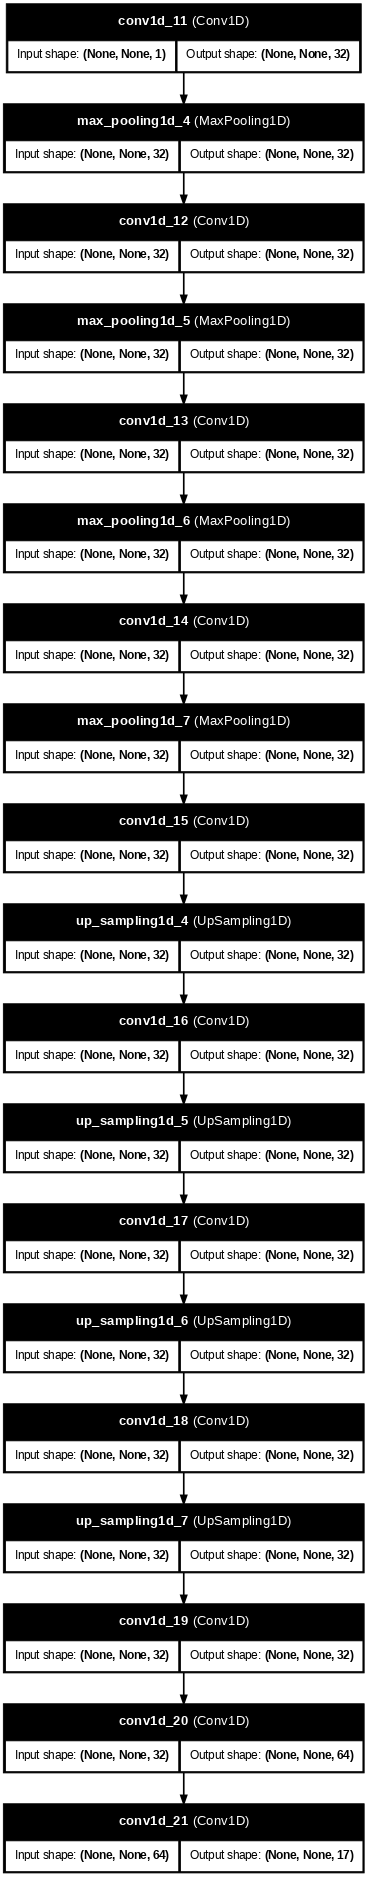

In [3]:
# Visualize using Keras
from tensorflow.keras.utils import plot_model
from IPython.display import Image, display

# Plot the model graph and save to a temporary file
plot_model(keras_model, to_file='model_plot.png', show_shapes=True, show_layer_names=True, dpi=60)

# Display the plot inline
display(Image('model_plot.png'))

In [ ]:
import matplotlib.pyplot as plt
import time

start = time.time()
length = my_dialed_sequence_signal.size
keras_pred = keras_model.predict(my_dialed_sequence_signal[:(length//8)*8].reshape(1, -1, 1), verbose=0)
end = time.time()

print("Inferenzzeit:", round(end - start, 2), "Sekunden")

cmap = plt.get_cmap("tab20")

colors = [cmap(i) for i in range(16)]  # Get 16 distinct colors

plt.figure(figsize=(10, 5))
plt.plot(my_dialed_sequence_signal)

for key_idx in range(keras_pred.shape[-1] - 1):  # last index represents pauses
    plt.plot(
        keras_pred[0, :, key_idx],
        label=f"{dtmf_gen.get_key(key_idx=key_idx)}",
        color=colors[key_idx],
    )
plt.legend(loc="upper center", bbox_to_anchor=(0.5, -0.15), ncol=8, title="Prognostizierte Tasten")
plt.title(f"Tatsächliche Wählsequenz: {' '.join(list(my_dialed_sequence_keys))}")
plt.show()

In [ ]:
predicted_key_sequence = dtmf_gen.decode_prediction(keras_pred)
print("Prognostizierte Wählsequenz:", predicted_key_sequence)
print(
    "Passt die Prognose zur tatsächlich gewählten Sequenz?:",
    "Ja!" if predicted_key_sequence == my_dialed_sequence_keys else "Nein!",
)

### Konvertierung des Keras Modells nach ONNX

In [4]:
import onnx
import tf2onnx
import tensorflow as tf

# This line sets the output names for the Keras model.
# It might throw an error, but the ONNX model should still be exported correctly.
keras_model.output_names = ["output"]

# Define the input signature for the model.
# This specifies the shape and type of the input tensor.
# 'None' in the shape indicates a variable dimension, meaning the model can accept inputs of varying sizes.
input_signature = [
    tf.TensorSpec([None, None, 1], tf.float32, name="input")
]

# Convert the Keras model to an ONNX model using the specified input signature and opset version.
# The opset version defines the set of operations available in the ONNX model.
onnx_model, _ = tf2onnx.convert.from_keras(keras_model, input_signature, opset=18)

# Save the converted ONNX model to a file.
onnx.save(onnx_model, "dtmf_classifier.onnx")

ERROR:tf2onnx.tfonnx:rewriter <function rewrite_constant_fold at 0x7aba781dd940>: exception `np.cast` was removed in the NumPy 2.0 release. Use `np.asarray(arr, dtype=dtype)` instead.


### Optimierung des ONNX Modells

In [5]:
import onnx
import onnxsim

# Define the path to the original ONNX model
model_path = "dtmf_classifier.onnx"

# Define the path where the simplified ONNX model will be saved
simplified_model_path = "dtmf_classifier.onnx"

# Load the original ONNX model from the specified file
onnx_model = onnx.load(model_path)

# Check the model to ensure it is well-formed and valid according to ONNX standards
onnx.checker.check_model(onnx_model)

# Simplify the ONNX model to make it more efficient and easier to understand
onnx_model_simp, check = onnxsim.simplify(onnx_model)

# Ensure that the simplified model is valid
assert check, "Simplified ONNX model could not be validated"

# Save the simplified ONNX model to the specified file
onnx.save(onnx_model_simp, simplified_model_path)

In [6]:
from techdays25 import onnx_utils

onnx_utils.netron_visualize("dtmf_classifier.onnx")

<IPython.core.display.Javascript object>

### FP16 Quantisierung des ONNX Modells

In [11]:
import onnx
from onnxconverter_common import float16

onnx_model = onnx.load("dtmf_classifier.onnx")
onnx.checker.check_model(onnx_model)
onnx_model_fp16 = float16.convert_float_to_float16(
    onnx_model,
    min_positive_val=1e-7,
    max_finite_val=1e4,
    keep_io_types=True,
    disable_shape_infer=False,
    op_block_list=None,
    node_block_list=None,
)
onnx.save(onnx_model_fp16, "dtmf_classifier_fp16.onnx")

### INT8 Quantisierung des ONNX Modells

### TensorRT Tests

TODO: Move below code to .py files and import!

In [12]:
from techdays25.dtmf_generation import DtmfGenerator

dtmf_gen = DtmfGenerator(
    dur_key=(0.04, 0.05),
    dur_pause=(0.03, 0.04),
    noise_factor=(0.0, 60.0),
    noise_freq_range=(0.0, 20000.0),
)

In [13]:
def get_gpu_type() -> str:
    """Get the type of GPU available on the system.

    This function checks if a CUDA-capable GPU is available using PyTorch.
    If a GPU is available, it returns the name of the GPU in lowercase with spaces replaced by underscores.
    If no GPU is available, it returns 'cpu'.

    Returns:
        str: The type of GPU available or 'cpu' if no GPU is available.
    """
    import torch

    if not torch.cuda.is_available():
        return "cpu"
    return "_".join(torch.cuda.get_device_name(0).lower().split(" "))

In [14]:
import sys
import time
from typing import Any

import numpy as np
import tensorrt as trt
from cuda import cuda, cudart
from pathlib import Path


def check_cuda_err(err: cuda.CUresult | cudart.cudaError_t) -> None:
    """Check for CUDA errors and raise an exception if an error is found.

    Args:
        err (Union[cuda.CUresult, cudart.cudaError_t]): The CUDA error code.

    Raises:
        RuntimeError: If a CUDA error is detected.
    """
    if isinstance(err, cuda.CUresult) and err != cuda.CUresult.CUDA_SUCCESS:
        raise RuntimeError(f"Cuda Error: {err}")
    if isinstance(err, cudart.cudaError_t):
        if err != cudart.cudaError_t.cudaSuccess:
            raise RuntimeError(f"Cuda Runtime Error: {err}")
    else:
        raise RuntimeError(f"Unknown error type: {err}")


def cuda_call(call: Any) -> Any:
    """Make a CUDA call and check for errors.

    Args:
        call (Any): The CUDA call to make.

    Returns:
        Any: The result of the CUDA call.
    """
    err, res = call[0], call[1:]
    check_cuda_err(err)
    if len(res) == 1:
        res = res[0]
    return res


# Wrapper for cudaMemcpy which infers copy size and does error checking
def memcpy_host_to_device(device_ptr: int, host_arr: np.ndarray) -> None:
    """Copy data from host to device.

    Args:
        device_ptr (int): The device pointer.
        host_arr (np.ndarray): The host array.
    """
    nbytes = host_arr.size * host_arr.itemsize
    cuda_call(
        cudart.cudaMemcpy(
            device_ptr, host_arr, nbytes, cudart.cudaMemcpyKind.cudaMemcpyHostToDevice
        )
    )


# Wrapper for cudaMemcpy which infers copy size and does error checking
def memcpy_device_to_host(host_arr: np.ndarray, device_ptr: int) -> None:
    """Copy data from device to host.

    Args:
        host_arr (np.ndarray): The host array.
        device_ptr (int): The device pointer.
    """
    nbytes = host_arr.size * host_arr.itemsize
    cuda_call(
        cudart.cudaMemcpy(
            host_arr, device_ptr, nbytes, cudart.cudaMemcpyKind.cudaMemcpyDeviceToHost
        )
    )


class MNISTEntropyCalibrator(trt.IInt8EntropyCalibrator2):
    """INT8 calibrator for our DTMF classifier model."""

    def __init__(
        self, training_data: str, cache_file: str, batch_size: int = 16
    ) -> None:
        """Initialize the MNISTEntropyCalibrator.

        Args:
            training_data (str): The path to the training data.
            cache_file (str): The path to the cache file.
            batch_size (int, optional): The batch size. Defaults to 16.
        """
        # Whenever you specify a custom constructor for a TensorRT class,
        # you MUST call the constructor of the parent explicitly.
        trt.IInt8EntropyCalibrator2.__init__(self)

        self.cache_file = cache_file

        # Every time get_batch is called, the next batch of size batch_size will be copied to the device and returned.
        # self.data = 2 * np.random.rand(32*batch_size, 2**12, 1).astype(np.float32) - 1.0
        # self.data = training_data
        self.data = dtmf_gen.generate_dataset(
            n_samples=32 * batch_size, t_length=2**12, with_labels=None
        ).astype(np.float32)
        # print(self.data.dtype)
        # self.data = self.data.astype(np.float32)
        self.batch_size = batch_size
        self.current_index = 0

        # Allocate enough memory for a whole batch.
        # self.device_input = cuda.mem_alloc(self.data[0].nbytes * self.batch_size)
        n_bytes = self.data[0].nbytes * self.batch_size
        # print("n_bytes", n_bytes)
        self.device_input = cuda_call(cudart.cudaMalloc(n_bytes))

    def get_batch_size(self) -> int:
        """Get the batch size.

        Returns:
            int: The batch size.
        """
        return self.batch_size

    # TensorRT passes along the names of the engine bindings to the get_batch function.
    # You don't necessarily have to use them, but they can be useful to understand the order of
    # the inputs. The bindings list is expected to have the same ordering as 'names'.
    def get_batch(self, names: list[str]) -> list[int] | None:
        """Get a batch of data.

        Args:
            names (List[str]): The names of the engine bindings.

        Returns:
            Optional[List[int]]: The device input pointer, or None if there is no more data.
        """
        # print("names:", names)
        if self.current_index + self.batch_size > self.data.shape[0]:
            return None

        current_batch = int(self.current_index / self.batch_size)
        if current_batch % 10 == 0:
            print(
                f"Calibrating batch {current_batch}, containing {self.batch_size} images"
            )

        batch = self.data[
            self.current_index : self.current_index + self.batch_size
        ].ravel()
        # cuda.memcpy_htod(self.device_input, batch)
        # memcpy_host_to_device(self.device_input, batch)
        memcpy_host_to_device(self.device_input, np.ascontiguousarray(batch))
        self.current_index += self.batch_size
        # print("Schalom!")
        return [int(self.device_input)]

    def read_calibration_cache(self) -> bytes | None:
        """Read the calibration cache.

        Returns:
            Optional[bytes]: The calibration cache, or None if it does not exist.
        """
        # If there is a cache, use it instead of calibrating again. Otherwise, implicitly return None.
        if Path.exists(self.cache_file):
            return Path(self.cache_file).read_bytes()
        return None

    def write_calibration_cache(self, cache: bytes) -> None:
        """Write the calibration cache.

        Args:
            cache (bytes): The calibration cache.
        """
        return  # for now
        Path(self.cache_file).write_bytes(cache)

In [15]:
from pathlib import Path

import tensorrt as trt

# You can set the logger severity higher to suppress messages (or lower to display more messages).
TRT_LOGGER: trt.Logger = trt.Logger(trt.Logger.VERBOSE)


def build_engine_onnx(
    model_file: str, trt_engine_path: str, precision: str
) -> None:
    """Builds a TensorRT engine from an ONNX model file.

    Args:
        model_file (str): The path to the ONNX model file.
        trt_engine_path (str): The path to save the TensorRT engine.
        precision (str): The precision mode to use ('fp16', 'int8', 'mixed').

    Returns:
        Optional[None]: Returns None if the engine creation fails.
    """
    seq_len: int = 2**12
    max_batch_size: list[int] = [1, 2, 4, 8, 16, 32, 64, 128, 256, 512]
    calibration_batch_size: int = 16
    builder: trt.Builder = trt.Builder(TRT_LOGGER)
    network: trt.INetworkDefinition = builder.create_network(0)
    config: trt.IBuilderConfig = builder.create_builder_config()
    parser: trt.OnnxParser = trt.OnnxParser(network, TRT_LOGGER)

    config.set_memory_pool_limit(
        trt.MemoryPoolType.WORKSPACE, 8 * 1 << 30
    )  # TODO: Constant

    # Load the Onnx model and parse it in order to populate the TensorRT network.
    if not parser.parse(Path(model_file).read_bytes()):
        print("ERROR: Failed to parse the ONNX file.")
        for error in range(parser.num_errors):
            print(parser.get_error(error))
        return

    for b in max_batch_size:
        profile: trt.IOptimizationProfile = builder.create_optimization_profile()
        profile.set_shape("input", [b//2 + 1, seq_len, 1], [b, seq_len, 1], [b, seq_len, 1])
        config.add_optimization_profile(profile)

    if precision in ["fp16", "int8", "mixed"]:
        if not builder.platform_has_fast_fp16:
            print("FP16 is not supported natively on this platform/device")
        config.set_flag(trt.BuilderFlag.FP16)
    if precision in ["int8", "mixed"]:
        if not builder.platform_has_fast_int8:
            print("INT8 is not supported natively on this platform/device")
        config.set_flag(trt.BuilderFlag.INT8)
        # config.set_flag(trt.BuilderFlag.OBEY_PRECISION_CONSTRAINTS)

        calib = MNISTEntropyCalibrator(
            "", cache_file="cache.file", batch_size=calibration_batch_size
        )
        config.int8_calibrator = calib

        calib_profile: trt.IOptimizationProfile = builder.create_optimization_profile()
        calib_profile.set_shape(
            "input",
            [calibration_batch_size, seq_len, 1],
            [calibration_batch_size, seq_len, 1],
            [calibration_batch_size, seq_len, 1],
        )
        config.set_calibration_profile(calib_profile)
        config.profiling_verbosity = trt.ProfilingVerbosity.DETAILED

        print("int 8 model")

    engine_bytes: bytes | None = builder.build_serialized_network(network, config)

    if engine_bytes is None:
        print("Failed to create the TensorRT engine")
        return
    trt.Runtime(TRT_LOGGER)

    # Save the engine to a file
    Path(trt_engine_path).write_bytes(engine_bytes)

    print(f"TensorRT engine saved to {trt_engine_path}")


# Example Usage
precision: str = "int8"
onnx_path: str = "dtmf_classifier.onnx"
trt_path: str = "dtmf_classifier_" + precision + "_" + get_gpu_type() + ".trt"
build_engine_onnx(onnx_path, trt_path, precision=precision)

<ipython-input-15-8a2a9458d709>:59: DeprecationWarning: Use Deprecated in TensorRT 10.1. Superseded by explicit quantization. instead.
  config.int8_calibrator = calib
<ipython-input-15-8a2a9458d709>:68: DeprecationWarning: Use Deprecated in TensorRT 10.1. Superseded by explicit quantization. instead.
  config.set_calibration_profile(calib_profile)


int 8 model
Calibrating batch 0, containing 16 images
Calibrating batch 10, containing 16 images
Calibrating batch 20, containing 16 images
Calibrating batch 30, containing 16 images
TensorRT engine saved to dtmf_classifier_int8_tesla_t4.trt


In [24]:
import time
from typing import Any

import numpy as np
import tensorrt as trt

DEBUG = False


def print_dbg(*x: Any) -> None:
    """Print debug information if DEBUG is set to True.

    Args:
        *x (Any): The information to print.
    """
    if DEBUG:
        print(x)

class CustomProfiler(trt.IProfiler):
    """Custom Profiler for logging layer-wise latency."""

    def __init__(self):
        trt.IProfiler.__init__(self)
        self.layers = {}

    def report_layer_time(self, layer_name, ms):
        if layer_name not in self.layers:
            self.layers[layer_name] = []

        self.layers[layer_name].append(ms)

class TensorRTInfer:
    # TODO: This code still has a memory leak. The memory allocated by
    # cudaMalloc has to be released!
    """Implements inference for the TensorRT engine."""

    def __init__(self, engine_path: str) -> None:
        """Initialize the TensorRTInfer class.

        Args:
            engine_path (str): The path to the serialized engine to load from disk.
        """
        # Load TRT engine
        self.logger = trt.Logger(trt.Logger.ERROR)
        trt.init_libnvinfer_plugins(self.logger, namespace="")
        # with open(engine_path, "rb") as f, trt.Runtime(self.logger) as runtime:
        #    assert runtime
        #    self.engine = runtime.deserialize_cuda_engine(f.read())
        runtime = trt.Runtime(self.logger)
        assert runtime
        self.engine = runtime.deserialize_cuda_engine(Path(engine_path).read_bytes())

        assert self.engine
        self.context = self.engine.create_execution_context()
        assert self.context

        # Some Infos about the engine
        print_dbg("num optimization profiles:", self.engine.num_optimization_profiles)
        print_dbg("num io tensors:", self.engine.num_io_tensors)

        # Create CUDA stream for asynchronous tasks
        _, self.stream = cudart.cudaStreamCreate()

        # Setup I/O bindings
        self.inputs = []
        self.outputs = []
        self.allocations = []
        for prof_idx in range(self.engine.num_optimization_profiles):
            for i in range(self.engine.num_io_tensors):
                name = self.engine.get_tensor_name(i)
                is_input = False
                if self.engine.get_tensor_mode(name) == trt.TensorIOMode.INPUT:
                    is_input = True
                dtype = np.dtype(trt.nptype(self.engine.get_tensor_dtype(name)))
                shape = self.engine.get_tensor_shape(name)
                if is_input and shape[0] < 0:
                    assert self.engine.num_optimization_profiles >= 1
                    profile_shape = self.engine.get_tensor_profile_shape(name, prof_idx)
                    print_dbg("profile_shape", name, profile_shape)
                    assert len(profile_shape) == 3  # min,opt,max

                    # Set the *max* profile as binding shape
                    self.switch_profile(prof_idx)
                    self.context.set_input_shape(name, profile_shape[2])
                    shape = self.context.get_tensor_shape(name)

                if not is_input:
                    shape = self.context.get_tensor_shape(name)
                    print_dbg("shape for output:", name, shape)

                if is_input:
                    self.batch_size = shape[0]
                size = dtype.itemsize
                for s in shape:
                    size *= s
                allocation = cuda_call(cudart.cudaMalloc(size))
                host_allocation = None if is_input else np.zeros(shape, dtype)
                binding = {
                    "index": i,
                    "name": name,
                    "dtype": dtype,
                    "shape": list(shape),
                    "allocation": allocation,
                    "host_allocation": host_allocation,
                }
                self.allocations.append(allocation)
                if is_input:
                    self.inputs.append(binding)
                else:
                    self.outputs.append(binding)
                print_dbg(
                    "{} '{}' with shape {} and dtype {}".format(
                        "Input" if is_input else "Output",
                        binding["name"],
                        binding["shape"],
                        binding["dtype"],
                    )
                )
            print_dbg()

        assert self.batch_size > 0
        assert len(self.inputs) > 0
        assert len(self.outputs) > 0
        assert len(self.allocations) > 0

    def enable_profiling(self, profiler: trt.IProfiler = None) -> None:
        """Enable TensorRT profiling.

        TensorRT will report time spent on each layer in stdout for each forward run.
        """
        if not self.context.profiler:
            self.context.profiler = CustomProfiler() if profiler is None else profiler

    def input_spec(self) -> tuple[list[int], np.dtype]:
        """Get the specs for the input tensor of the network. Useful to prepare memory allocations.

        Returns:
            Tuple[List[int], np.dtype]: Two items, the shape of the input tensor and its (numpy) datatype.
        """
        # TODO: Index 0 is wrong
        return self.inputs[0]["shape"], self.inputs[0]["dtype"]

    def output_spec(self) -> list[tuple[list[int], np.dtype]]:
        """Get the specs for the output tensors of the network. Useful to prepare memory allocations.

        Returns:
            List[Tuple[List[int], np.dtype]]: A list with two items per element, the shape and (numpy) datatype of each output tensor.
        """
        specs = []
        for o in self.outputs:
            specs.append((o["shape"], o["dtype"]))
        return specs

    def switch_profile(self, idx: int) -> None:
        """Switch to a different optimization profile.

        Args:
            idx (int): The index of the optimization profile to switch to.
        """
        self.context.set_optimization_profile_async(
            idx, self.stream
        )

    def infer(self, batch: np.ndarray) -> list[np.ndarray]:
        """Execute inference on a batch of images.

        Args:
            batch (np.ndarray): A numpy array holding the image batch.

        Returns:
            List[np.ndarray]: A list of outputs as numpy arrays.
        """
        # If the optimization profile does not match, change it here:
        # In our setup the opt. profiles are selected in a way that the
        # optimal batch sizes are powers of 2. In practice, one would not do
        # it in this way:
        # TODO: If the profile does not fit in the range, find the profile with
        # the closest optimal settings...
        if True:
          expected_profile = int(np.log2(batch.shape[0]))
          if self.context.active_optimization_profile != expected_profile:
              print("Changing to profile", expected_profile)
              self.switch_profile(expected_profile)

          if self.context.get_tensor_shape("input") != batch.shape:
              print("Changing batch size for inference!")

              # Adapt the input shape:
              self.context.set_input_shape("input", batch.shape)
        print_dbg(
            "self.engine.get_tensor_shape(input)", self.engine.get_tensor_shape("input")
        )
        print_dbg(
            "self.context.get_tensor_shape(input)",
            self.context.get_tensor_shape("input"),
        )
        print_dbg(
            "self.context.get_tensor_shape(output)",
            self.context.get_tensor_shape("output"),
        )
        print_dbg()

        o_idx = self.context.active_optimization_profile
        print_dbg("Active output index (opt. profile)", o_idx)

        # Copy I/O and Execute
        memcpy_host_to_device(self.inputs[o_idx]["allocation"], batch)

        self.context.execute_v2(self.allocations)
        memcpy_device_to_host(
            self.outputs[o_idx]["host_allocation"], self.outputs[o_idx]["allocation"]
        )

        return [self.outputs[o_idx]["host_allocation"]]



"""Main function to run the TensorRT inference."""
trt_path = "/content/dtmf_classifier_int8_tesla_t4.trt"
seq_len = 2**12
trt_infer = TensorRTInfer(trt_path)
#trt_infer.enable_profiling() # Use only for debugging/analysis purposes, since it slows down inference

print("Starting inference")
if True:
    trt_infer.switch_profile(6)
    spec = trt_infer.input_spec()
    print("spec", spec)
    # batch = my_dialed_sequence_signal.reshape(1, -1, 1).astype(np.float32)
    X, Y = dtmf_gen.generate_dataset(n_samples=256, t_length=seq_len)
    o = trt_infer.infer(X.astype(np.float32))[0][: X.shape[0]]
    #o = keras_model.predict(X.astype(np.float32), verbose=0)
    print("o.shape", o.shape)

    thresholded = (o > 0.5).astype(int)
    print((thresholded == Y).sum() / Y.size)
    for iidx in range(X.shape[0]):
        predicted_key_sequence = dtmf_gen.decode_prediction(o[iidx])
        original_key_sequence = dtmf_gen.decode_prediction(Y[iidx])
        if predicted_key_sequence != original_key_sequence:
            print("predicted_key_sequence", predicted_key_sequence)
            print("original_key_sequence", original_key_sequence)
        else:
            print("OK", predicted_key_sequence)
    print("Done!")
else:
    print("No input provided, running in benchmark mode")
    trt_infer.switch_profile(0)
    spec = trt_infer.input_spec()
    # TODO:
    spec = (512, 4096, 1), np.float32

    rng = np.random.default_rng()
    batch = rng.random(spec[0]).astype(spec[1])
    # batch = np.random.rand(*spec[0]).astype(spec[1])

    print("batch.shape", batch.shape)
    print("batch.dtype", batch.dtype)
    print("min/max/mean", batch.min(), batch.max(), batch.mean())
    iterations = 100
    times = []
    for i in range(20):  # GPU warmup iterations
        trt_infer.infer(batch)
    for i in range(iterations):
        start = time.time()
        o = trt_infer.infer(batch)
        times.append(time.time() - start)
        print(f"Iteration {i + 1} / {iterations}", end="\r")
    print("Benchmark results include time for H2D and D2H memory copies")
    print(f"Average Latency: {1000 * np.average(times):.3f} ms")
    print(f"Average Throughput: {trt_infer.batch_size / np.average(times):.1f} ips")

print()
print("Finished Processing")


Starting inference
spec ([1, 4096, 1], dtype('float32'))
Changing to profile 8
Changing batch size for inference!
o.shape (256, 4096, 17)
0.9966451420503504
OK *
OK C
OK 4
OK D
OK #
OK 5
OK C
OK A
OK 4
OK 7
OK 4
OK D
OK 4
OK *
OK 2
OK 6
OK 6
OK D
OK D
OK A
OK 9
OK 0
OK B
OK C
OK 9
OK #
OK 5
OK 9
OK 6
OK 7
OK 9
predicted_key_sequence 
original_key_sequence 7
OK B
OK 8
OK B
OK 7
OK 5
OK 1
OK A
OK 3
OK A
OK #
OK 0
OK 4
OK 4
OK *
OK *
OK D
OK #
OK 0
OK 5
OK D
OK 4
OK #
OK 0
OK A
OK 4
OK *
OK 3
OK 3
OK 9
OK 2
OK 3
predicted_key_sequence 0#
original_key_sequence 0
predicted_key_sequence 
original_key_sequence 1
OK 5
OK #
OK 6
OK 0
predicted_key_sequence 8
original_key_sequence 7
OK A
OK #
OK 9
OK 1
OK 3
OK #
OK 2
OK 8
OK 4
OK 3
OK B
OK B
OK 3
OK B
OK 2
OK B
OK 5
OK 7
OK 2
OK C
OK 7
OK #
OK 8
OK #
OK D
OK #
OK 4
OK 3
OK 3
OK 8
OK *
OK C
OK 6
OK 9
OK *
OK A
OK 6
OK 4
OK 7
OK A
OK 8
OK 5
OK 3
OK 3
OK 8
OK 9
OK A
OK 9
OK *
OK 0
OK 2
OK 9
OK 9
OK 5
OK D
OK B
OK 9
OK *
OK A
OK 9
OK 2
OK 3
OK B
OK 

In [ ]:
X.shape, o.shape

In [ ]:
import matplotlib.pyplot as plt
plt.plot(X[3,:,0])

In [ ]:
trt_path

In [ ]:
import pandas as pd
df_fp16 = pd.DataFrame([ (k, np.mean(v)) for k, v in trt_infer.context.profiler.layers.items()], columns=["Layer", "Time (ms)"])

In [ ]:
df = pd.concat([df_int8.set_index("Layer").add_suffix(' int8'), df_fp16.set_index("Layer").add_suffix(' fp16')], axis=1)

In [ ]:
df["diff"] = df["Time (ms) fp16"] - df["Time (ms) int8"]

In [ ]:
pd.set_option('display.max_rows', None)  # Display up to 50 columns
df.sort_values("diff", ascending=False)

In [ ]:
for k, v in trt_infer.context.profiler.layers.items():
  print(k[-40:], np.sum(v))

In [ ]:
trt_infer.profiler.report_layer_time(0)

## Modell-Experimente

### Laden der einzelnen Modelle für die Inferenz

In [17]:
from techdays25.onnx_utils import (
    OnnxModel,
    benchmark_models_on_batch_size,
    plot_benchmark_results,
)
from pathlib import Path

# FP32 ONNX Model
onnx_classifier = OnnxModel("dtmf_classifier.onnx")

# FP16 ONNX Model
onnx_classifier_fp16 = OnnxModel("dtmf_classifier_fp16.onnx")

# TODO: INT8 ONNX model

# INT8 TensorRT Model
tensorrt_classifier_int8 = TensorRTInfer(f"dtmf_classifier_int8_{get_gpu_type()}.trt")

In [ ]:
# TODO: Allow to select model here:
onnx_prediction = onnx_classifier.predict(
    my_dialed_sequence_signal.reshape(1, -1, 1).astype(np.float32)
)
predicted_key_sequence = dtmf_gen.decode_prediction(onnx_prediction)
print("Predicted Sequence:", predicted_key_sequence)
print(
    "Passt die Prognose zur tatsächlichen gewählten Sequenz?:",
    "Ja!" if predicted_key_sequence == my_dialed_sequence_keys else "Nein!",
)

In [ ]:
# TODO: Validate ONNX models and Keras Model on Validation/Test data

### Laufzeitmessung (Latenz) der individuellen Modelle

In [ ]:
n_runs = 100
n_warmup = 20
signal_length = 2**12
batch_sizes = [2**i for i in range(10)]

model_dict = {
    "keras (FP32)": lambda x: keras_model.predict(x, verbose=0),
    "ONNX (FP32)": onnx_classifier.predict,
    "ONNX (FP16)": onnx_classifier_fp16.predict,
    # "TRT (FP32)": tensorrt_classifier_fp32.infer,
    # "TRT (FP16)": tensorrt_classifier_fp16.infer,
    "TRT (INT8)": tensorrt_classifier_int8.infer,
}

dtmf_benchmark_results = benchmark_models_on_batch_size(
    model_dict=model_dict,
    input_shape=(signal_length, 1),
    batch_sizes=batch_sizes,
    n_runs=n_runs,
    n_warmup=n_warmup,
)

keras (FP32)
  b=1....................................................................................................
  b=2....................................................................................................
  b=4....................................................................................................
  b=8

In [ ]:
show_models = [
    'keras',
    'ONNX (FP32)',
     'ONNX (FP16)',
     'TRT (INT8)'
]

plot_benchmark_results(
    results={k: v for k,v in dtmf_benchmark_results.items() if k in show_models},
    title="Inferenzzeiten von DTMF-Klassifikationsmodellen",
    xscale="log",
    yscale=None)

In [ ]:
dtmf_benchmark_results['ONNX (FP16)'][512].mean() / dtmf_benchmark_results['TRT (INT8)'][512].mean()
# dtmf_classifier_slightly_bigger_transposed_conv: 1.39
# dtmf_classifier_residual2 : 1.26
# dtmf_classifier_xl_residual: 1.37


In [ ]:
import pandas as pd
from IPython.display import display, HTML

df_runtimes = pd.DataFrame( {k: v.median(axis=0)*1000.0 for k,v in dtmf_benchmark_results.items()} )
df_runtimes.index.name = 'Batchgröße'
display(HTML("<h2>Durchschnittliche Inferenzzeiten in Millisekunden</h2>"))
display(df_runtimes)

In [ ]:
# @title Speedup der quantisierten Modelle ggü. Keras-Modell {display-mode: "form"}

def plot_speedup(df, reference_model, batch_size):
    # Ensure the batch size exists in the DataFrame
    if batch_size not in df.index:
        raise ValueError(f"Batch size {batch_size} not found in the DataFrame index.")

    # Ensure the reference model exists in the DataFrame columns
    if reference_model not in df.columns:
        raise ValueError(f"Reference model {reference_model} not found in the DataFrame columns.")

    # Extract the runtimes for the given batch size
    runtimes = df.loc[batch_size]

    # Calculate the speedup relative to the reference model
    reference_runtime = runtimes[reference_model]
    speedup = reference_runtime / runtimes

    # Plot the bar chart
    plt.figure(figsize=(7, 5))

    #colors = plt.cm.viridis(np.linspace(0, 1, len(speedup)))  # Use a colormap for different colors
    cmap = plt.get_cmap("tab10")

    colors = [cmap(i) for i in range(16)]  # Get 16 distinct colors
    bars = speedup.plot(kind='bar', color=colors)

    # Annotate each bar with the speedup value
    for bar in bars.patches:
        height = bar.get_height()
        bars.annotate(f'x{height:.2f}',
                      xy=(bar.get_x() + bar.get_width() / 2, height-0.1),
                      xytext=(0, 3),  # 3 points vertical offset
                      textcoords="offset points",
                      ha='center', va='bottom')

    plt.title(f'Speedup relativ zu "{reference_model}" für Batch-Größe {batch_size}')
    plt.xlabel('Modell')
    plt.ylabel('Speedup')
    plt.xticks(rotation=45)
    plt.grid(axis='y', which="both")
    plt.show()

plot_speedup(df_runtimes, reference_model='keras', batch_size=512)

## Genauigkeit der (quantisierten) Modelle

In [ ]:
n_runs = 10
signal_length = 2**12
batch_size = 256
class_threshold = 0.5
noise_levels = [10*i for i in range(20)]

model_dict = {
    "keras (FP32)": lambda x: keras_model.predict(x, verbose=0),
    "ONNX (FP32)": onnx_classifier.predict,
    "ONNX (FP16)": onnx_classifier_fp16.predict,
    "TRT (INT8)": tensorrt_classifier_int8.infer,
}

In [ ]:
from techdays25.dtmf_generation import DtmfGenerator

dtmf_gen = DtmfGenerator(
    dur_key=(0.02, 0.05),
    dur_pause=(0.01, 0.03),
    noise_factor=None,
    noise_freq_range=(0.0, 20000.0),
)

In [ ]:
noise_level = noise_levels[3]
X_val, Y_val = dtmf_gen.generate_dataset(n_samples=batch_size, t_length=signal_length, noise_factor=noise_level)
print(X_val.shape, Y_val.shape, X_val.min(), X_val.max())

In [ ]:
model_fnc = onnx_classifier.predict #tensorrt_classifier_int8.infer
model_fnc = tensorrt_classifier_int8.infer

pred = model_fnc(X_val.astype(np.float32))[0] # TODO: prediction should NOT be a LIST

# Compute Accuracy
thresholded = (pred > class_threshold).astype(int)

accuracy = (thresholded == Y_val).sum() / Y_val.size

# TODO: create one WAV example for each noise level

In [ ]:
pred.shape, accuracy

In [ ]:
dtmf_gen.decode_prediction(pred[0]), dtmf_gen.decode_prediction(Y_val[0])

## Reproduktion des Modells/Erneutes Training des Keras Modells (Optional)

TODO: Hinweis, dass Sitzung neugesrartet werden sollte

In [ ]:
# from collections.abc import Callable
from pathlib import Path

import numpy as np
import tensorflow as tf
from tensorflow.keras import layers
from scipy.io import wavfile

In [ ]:
from techdays25.dtmf_generation import DtmfGenerator
from techdays25.dtmf_models import build_dtmf_classifier_model

dtmf_gen = DtmfGenerator(
    dur_key=(0.02, 0.1),
    dur_pause=(0.01, 0.05),
    noise_factor=(0.0,60.0),
    noise_freq_range=(0.0, 20000.0),
)

In [ ]:
# TODO add use_bias=False to Conv1D layers

# This model can be used as a basis to analyze it in the frequency domain.
# It appears to show some interesting insights in the frequency domain.
import numpy as np
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv1D, Concatenate, Activation

# Define the input shape
input_shape = (None, 1)  # Example: sequence length is variable, and there are 3 features per time step

# Input layer
inputs = Input(shape=input_shape, name="input")

# Learn a filter for the input:
conv_layer_input = Conv1D(filters=1, kernel_size=32, padding='same', activation='linear', name=f'input_filter')(inputs)

# Do some downsampling first
avg_pooled = layers.AveragePooling1D(padding="same", pool_size=2)(conv_layer_input)
avg_pooled_1 = layers.AveragePooling1D(padding="same", pool_size=2)(avg_pooled)

# Define 8 different Conv1D layers
conv_layers = []
for i in range(4):
    conv_layer = Conv1D(filters=1, kernel_size=64, padding='same', activation='linear', name=f'conv_1_{i+1}')(avg_pooled_1)

    max_pooled_layer =  layers.AveragePooling1D(padding="same", pool_size=2)(conv_layer)
    conv_layer_1 = Conv1D(filters=1, kernel_size=64, padding='same', activation='linear', name=f'conv_2_{i+1}')(max_pooled_layer)

    max_pooled_layer_2 = layers.MaxPooling1D(padding="same")(conv_layer_1)
    conv_layer_2 = Conv1D(filters=1, kernel_size=64, padding='same', activation='linear', name=f'conv_3_{i+1}')(max_pooled_layer_2)
    upsamp_layer = layers.UpSampling1D(size=16)(conv_layer_2)

    conv_layers.append(upsamp_layer)

# Concatenate the outputs of the 8 Conv1D layers
concatenated = Concatenate(name="concat")(conv_layers)

# Final 1x1 Conv1D layer with softmax activation
output = Conv1D(filters=dtmf_gen.get_num_keys() + 1, kernel_size=1, activation='softmax', name="final_conv")(concatenated)

# Create the model
model = Model(inputs=inputs, outputs=output, name="MultiConv1DModel")

# Create an additional model to output the concatenated layer
intermediate_model = Model(inputs=inputs, outputs=concatenated, name="IntermediateModel")

# Print the model summary
model.summary()


In [ ]:
# TODO: check model architecture

from tensorflow.keras import layers
import tensorflow as tf

# Define the input shape
input_shape = (None, 1)
num_classes = dtmf_gen.get_num_keys() + 1

model = tf.keras.Sequential([
        layers.Input(shape=input_shape),

        # roughly, some temporal autoencoder structure
        layers.Conv1D(32,kernel_size=32, activation="elu",padding="same"),
        layers.MaxPooling1D(padding="same"),
        layers.Conv1D(32, kernel_size=32, activation="elu", padding="same"),
        layers.MaxPooling1D(padding="same"),
        layers.Conv1D(32, kernel_size=32, activation="elu", padding="same"),
        layers.MaxPooling1D(padding="same"),
        layers.Conv1D(32, kernel_size=32, activation="elu", padding="same"),
        layers.MaxPooling1D(padding="same"),
        layers.Conv1D(32, kernel_size=32, activation="elu", padding="same"),
        layers.Conv1DTranspose(32, kernel_size=32,strides=2, padding="same"),
        layers.Conv1D(32, kernel_size=32, activation="elu", padding="same"),
        layers.Conv1DTranspose(32, kernel_size=32,strides=2, padding="same"),
        layers.Conv1D(32, kernel_size=32, activation="elu", padding="same"),
        layers.Conv1DTranspose(32, kernel_size=32,strides=2, padding="same"),
        layers.Conv1D(32, kernel_size=32, activation="elu", padding="same"),
        layers.Conv1DTranspose(32, kernel_size=32,strides=2, padding="same"),
        layers.Conv1D(32, kernel_size=32, activation="elu", padding="same"),

        # Final layer
        layers.Conv1D(num_classes, kernel_size=1, activation="softmax", padding="same"),
    ])

model.summary()

In [ ]:
X_train, Y_train = dtmf_gen.generate_dataset(n_samples=1024, t_length=2**14)
X_val, Y_val = dtmf_gen.generate_dataset(n_samples=64, t_length=2**16)

print(X_train.shape, Y_train.shape, X_train.min(), X_train.max())
print(X_val.shape, Y_val.shape, X_val.min(), X_val.max())

In [ ]:
# TODO: Schöner
from matplotlib import pyplot as plt
idx = 7
plt.plot(X_train[idx,:,0])

In [ ]:
# TODO: Schöner
from matplotlib import pyplot as plt
idx = 4
plt.plot(X_val[idx,:,0])

In [ ]:
from tensorflow.keras.utils import plot_model
from IPython.display import Image, display

# Plot the model graph and save to a temporary file
#plot_model(model, to_file='model_plot.png', show_shapes=False, show_layer_names=True, dpi=300)

# Display the plot inline
#display(Image('model_plot.png'))

In [ ]:
#model = build_dtmf_classifier_model((None, 1), dtmf_gen.get_num_keys() + 1)

adam = tf.keras.optimizers.Adam(learning_rate=0.001)
model.compile(
    optimizer=adam, loss="categorical_crossentropy", metrics=["accuracy"]
)  # multi-label
#model.summary()

In [ ]:
model.fit(X_train, Y_train, batch_size=64, epochs=20, validation_data=(X_val, Y_val))

In [ ]:
model.save("dtmf_classifier.keras")

In [ ]:
# load again to make sure...
model = tf.keras.models.load_model("dtmf_classifier.keras")
model.summary()

In [ ]:
import IPython

idx = 9

# TODO: Duplicate Code below:
pred = model.predict(X_val[idx : idx + 1])
cmap = plt.get_cmap("tab20")
colors = [cmap(i) for i in range(16)]  # Get 16 distinct colors

plt.figure(figsize=(10, 5))
plt.plot(X_val[idx, :, 0])

for key_idx in range(pred.shape[-1] - 1):  # last index represents pauses
    plt.plot(
        pred[0, :, key_idx],
        label=f"{dtmf_gen.get_key(key_idx=key_idx)}",
        color=colors[key_idx],
    )
plt.legend(loc="upper center", bbox_to_anchor=(0.5, -0.15), ncol=8)
plt.show()

wavfile.write(
    "val.wav",
    dtmf_gen.get_sample_rate(),
    (X_val[idx] * np.iinfo(np.int32).max).flatten().astype(np.int32),
)
IPython.display.Audio("val.wav")

In [ ]:
# Compute Accuracy
pred = model.predict(X_val)
thresholded = (pred > 0.5).astype(int)

(thresholded == Y_val).sum() / Y_val.size

# TRTExec

In [ ]:
!uname -a
!cat /etc/os-release
!ls -l /usr/local
!nvcc --version
!nvidia-smi

# Experiments with different Data Types

In [ ]:
# Import tensorrt_libs

# Import ONNX dependencies
from onnxruntime.quantization import (
    CalibrationDataReader,
)

# Further Experiments with Data Types

In [ ]:
import sys

sys.float_info

In [ ]:
import numpy as np
import torch


def float_to_binary_fp32(num: float) -> str:
    """Converts a built-in floating point number (64-bit) to its FP32 binary representation.

    Args:
        num (float): The floating point number to convert.

    Returns:
        str: A string representing the binary format of the floating point number.
    """
    print("fp32:", num)
    return "".join(f"{c:0>8b}" for c in struct.pack("!f", num))


def float_to_binary_fp16(num: float) -> str:
    """Converts a builtin-in floating point number to a 16-bit floating point number and returns its binary representation.

    Args:
        num (float): The floating point number to convert.

    Returns:
        str: A string representing the binary format of the 16-bit floating point number.
    """
    # Convert the number to a float16
    float16_num = np.float16(num)

    print("fp16:", float16_num)

    # Convert the float16 to bytes
    float16_bytes = float16_num.tobytes()

    # Convert the bytes to a binary string (big endian notation)
    return "".join(f"{byte:08b}" for byte in reversed(float16_bytes))


def float_to_binary_bf16(num: float) -> str:
    """Converts a floating point number to bfloat16  and returns its binary representation.

    Args:
        num (float): The floating point number to convert.

    Returns:
        str: A string representing the binary format of the bfloat16 floating point number.
    """
    # Create a tensor with the given number
    a = torch.Tensor([num])

    # Convert the tensor to bfloat16
    bf = a.bfloat16()

    print("bf16", bf)

    # Convert the bfloat16 tensor to bytes
    bf_bytes = bytes(bf.untyped_storage())

    # Convert the bytes to a binary string (big endian notation)
    return "".join(f"{byte:08b}" for byte in reversed(bf_bytes))


def float_to_binary_fp8_e4m3(num: float) -> str:
    """Converts a  floating point number to float8 (e4m3) and returns its binary representation.

    Args:
        num (float): The floating point number to convert.

    Returns:
        str: A string representing the binary format of the float8 (e4m3) floating point number.
    """
    # Create a tensor with the given number
    a = torch.Tensor([num])

    # Convert the tensor to float8 (e4m3)
    bf = a.to(torch.float8_e4m3fn)

    print("fp8_e4m3", bf)

    # Convert the float8 tensor to bytes
    bf_bytes = bytes(bf.untyped_storage())

    # Convert the bytes to a binary string
    return "".join(f"{byte:08b}" for byte in bf_bytes)


def float_to_binary_fp8_e5m2(num: float) -> str:
    """Converts a floating point number to float8 (e5m2)  and returns its binary representation.

    Args:
        num (float): The floating point number to convert.

    Returns:
        str: A string representing the binary format of the float8 (e5m2) floating point number.
    """
    # Create a tensor with the given number
    a = torch.Tensor([num])

    # Convert the tensor to float8 (e5m2)
    bf = a.to(torch.float8_e5m2)

    print("fp8_e5m2", bf)

    # Convert the float8 tensor to bytes
    bf_bytes = bytes(bf.untyped_storage())

    # Convert the bytes to a binary string
    return "".join(f"{byte:08b}" for byte in bf_bytes)


def float_to_binary_int(num: float, bit_length: int = 8) -> str:
    """Converts a floating point number to its binary representation as an integer.

    Args:
        num (float): The floating point number to convert.
        bit_length (int, optional): The bit length of the binary representation. Defaults to 8.

    Returns:
        str: A string representing the binary format of the integer part of the floating point number.
    """
    return np.binary_repr(round(num), width=bit_length)


num = -8.875074538462327 - 2**-7 - 2**-8
float_to_binary_fp32(num)
# float_to_binary_fp16(num)
# float_to_binary_bf16(num)
# float_to_binary_fp8_e4m3(num)
# float_to_binary_fp8_e5m2(num)
# float_to_binary_int(num, bit_length=8)

In [ ]:
-num - 2**3 - 2**-1 - 2**-2 - 2**-3 - 2**-7 - 2**-8


(int("1111011100011101", base=2) - 2**16) / 2**8

In [ ]:
import numpy as np

s = "1100100001111100"
b = int(s, base=2).to_bytes(2, "little")
print(b)
c = np.frombuffer(b, dtype=np.float16, count=1)
print(c)

In [ ]:
# Binary string
binary_string = "11000001000011111000101100101011"

# Convert the binary string to an integer
binary_int = int(binary_string, 2)

# Convert the integer to bytes (4 bytes for float32)
binary_bytes = binary_int.to_bytes(4, byteorder="big")

# Unpack the bytes to a float
float_value = struct.unpack(">f", binary_bytes)[0]

print(float_value)

# Analyze Model in Frequency domain

In [ ]:
from collections.abc import Callable

import matplotlib.pyplot as plt
import numpy as np


def multiple_formatter(
    denominator: int = 2, number: float = np.pi, latex: str = r"\pi"
) -> Callable[[float, int], str]:
    """Creates a formatter function for matplotlib that formats axis labels as multiples of a given number.

    Args:
        denominator (int, optional): The denominator to use for the fraction representation. Defaults to 2.
        number (float, optional): The base number to use for the multiples. Defaults to np.pi.
        latex (str, optional): The LaTeX string to use for the base number.

    Returns:
        Callable[[float, int], str]: A function that formats a given value as a LaTeX fraction of the base number.
    """

    def gcd(a: int, b: int) -> int:
        """Computes the greatest common divisor of two integers.

        Args:
            a (int): The first integer.
            b (int): The second integer.

        Returns:
            int: The greatest common divisor of a and b.
        """
        while b:
            a, b = b, a % b
        return a

    def _multiple_formatter(x: float, pos: int) -> str:
        """Formats a given value as a LaTeX fraction of the base number.

        Args:
            x (float): The value to format.
            pos (int): The position (not used in this implementation).

        Returns:
            str: The formatted string.
        """
        den = denominator
        num = np.int64(np.rint(den * x / number))
        com = gcd(num, den)
        (num, den) = (int(num / com), int(den / com))
        if den == 1:
            if num == 0:
                return r"$0$"
            if num == 1:
                return rf"${latex}$"
            if num == -1:
                return rf"$-{latex}$"
            return rf"${num}{latex}$"
        if num == 1:
            return rf"$\frac{{{latex}}}{{{den}}}$"
        if num == -1:
            return rf"$\frac{{-{latex}}}{{{den}}}$"
        return rf"$\frac{{{num}{latex}}}{{{den}}}$"

    return _multiple_formatter


class Multiple:
    """A class to create locators and formatters for matplotlib axes based on multiples of a given number."""

    def __init__(
        self, denominator: int = 2, number: float = np.pi, latex: str = r"\pi"
    ):
        """Initializes the Multiple class with the given parameters.

        Args:
            denominator (int, optional): The denominator to use for the fraction representation. Defaults to 2.
            number (float, optional): The base number to use for the multiples. Defaults to np.pi.
            latex (str, optional): The LaTeX string to use for the base number.
        """
        self.denominator = denominator
        self.number = number
        self.latex = latex

    def locator(self) -> plt.MultipleLocator:
        """Creates a locator for matplotlib axes based on multiples of the base number.

        Returns:
            plt.MultipleLocator: A locator for matplotlib axes.
        """
        return plt.MultipleLocator(self.number / self.denominator)

    def formatter(self) -> plt.FuncFormatter:
        """Creates a formatter for matplotlib axes that formats labels as multiples of the base number.

        Returns:
            plt.FuncFormatter: A formatter for matplotlib axes.
        """
        return plt.FuncFormatter(
            multiple_formatter(self.denominator, self.number, self.latex)
        )

In [ ]:
#
# Copyright (c) 2011 Christopher Felton
#
# This program is free software: you can redistribute it and/or modify
# it under the terms of the GNU Lesser General Public License as published by
# the Free Software Foundation, either version 3 of the License, or
# (at your option) any later version.
#
# This program is distributed in the hope that it will be useful,
# but WITHOUT ANY WARRANTY; without even the implied warranty of
# MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.  See the
# GNU Lesser General Public License for more details.
#
# You should have received a copy of the GNU Lesser General Public License
# along with this program.  If not, see <http://www.gnu.org/licenses/>.
#

# The following is derived from the slides presented by
# Alexander Kain for CS506/606 "Special Topics: Speech Signal Processing"
# CSLU / OHSU, Spring Term 2011.

import matplotlib.pyplot as plt
import numpy as np
from matplotlib import patches


def zplane(b, a, filename=None):
    """Will probably be removed soon.

    Args:
        b (_type_): _description_
        a (_type_): _description_
        filename (_type_, optional): _description_. Defaults to None.

    Returns:
        _type_: _description_
    """
    # get a figure/plot
    ax = plt.subplot(111)

    # create the unit circle
    uc = patches.Circle((0, 0), radius=1, fill=False, color="black", ls="dashed")
    ax.add_patch(uc)

    # The coefficients are less than 1, normalize the coeficients
    if np.max(b) > 1:
        kn = np.max(b)
        b = b / float(kn)
    else:
        kn = 1

    if np.max(a) > 1:
        kd = np.max(a)
        a = a / float(kd)
    else:
        kd = 1

    # Get the poles and zeros
    # p = np.roots(a)
    # z = np.roots(b)
    # k = kn/float(kd)
    # Markus:
    z, p, k = signal.tf2zpk(b, a)

    # Plot the zeros and set marker properties
    t1 = plt.plot(z.real, z.imag, "go", ms=10)
    plt.setp(
        t1,
        markersize=10.0,
        markeredgewidth=1.0,
        markeredgecolor="k",
        markerfacecolor="g",
    )

    # Plot the poles and set marker properties
    t2 = plt.plot(p.real, p.imag, "rx", ms=10)
    plt.setp(
        t2,
        markersize=12.0,
        markeredgewidth=3.0,
        markeredgecolor="r",
        markerfacecolor="r",
    )

    ax.spines["left"].set_position("center")
    ax.spines["bottom"].set_position("center")
    ax.spines["right"].set_visible(False)
    ax.spines["top"].set_visible(False)

    # set the ticks
    r = 1.5
    plt.axis("scaled")
    plt.axis([-r, r, -r, r])
    ticks = [-1, -0.5, 0.5, 1]
    plt.xticks(ticks)
    plt.yticks(ticks)

    if filename is None:
        plt.show()
    else:
        plt.savefig(filename)

    return z, p, k

In [ ]:
import tensorflow as tf

In [ ]:
model = tf.keras.models.load_model("dtmf_classifier.keras")

# Recreate the intermediate model
intermediate_output = loaded_model.get_layer('concat').output
recreated_intermediate_model = Model(inputs=loaded_model.input, outputs=intermediate_output, name="RecreatedIntermediateModel")

In [ ]:
# Assuming 'model' is your Keras model and 'n' is the index of the layer you are interested in
n = 14  # Example: Get the weights and name of the 3rd layer (indexing starts from 0)

# Access the n-th layer
nth_layer = model.layers[n]

# Get the weights of the n-th layer
weights = nth_layer.get_weights()

# Get the name of the n-th layer
layer_name = nth_layer.name

# Print the name and weights of the n-th layer
print(f"Name der {n + 1}. Schicht (Index {n}): {layer_name}")
# print(f"Gewichte der {n+1}. Schicht (Index {n}):\n", weights)

In [ ]:
weights[0].shape  # (kernel_size, input_channels, num_filters)

In [ ]:
frequencies = [8*2.0 * np.pi * f / dtmf_gen.get_sample_rate() for f in dtmf_gen.FREQS]
frequencies

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from scipy import signal

fig = plt.figure(figsize=(10, 2 * 6))

for z in range(1):
    dil_rate = 1
    b = weights[0][:, 0, z]  # (kernel_size, channels, num_filters)
    w, h = signal.freqz(b[::-1])
    if dil_rate > 1:
        m = b.shape
        out = np.zeros((dil_rate) * m[0], dtype=b.dtype)
        out[::dil_rate] = b
        b = out[: -dil_rate + 1]
        w, h = signal.freqz(b[::-1])

    ax1 = fig.add_subplot(421 + z)

    ax1.set_title("q=" + str(dil_rate))

    # plt.plot(w, 20 * np.log10(abs(h)), 'b')
    plt.plot(w, abs(h), "b")
    if z % 2 == 0:
        plt.ylabel("Amplitude [dB]", color="b")
    if z // 2 == 1:
        plt.xlabel(r"$\hat\omega$ [rad]")  # Frequency [rad/sample]

    ax2 = ax1.twinx()
    angles = np.unwrap(np.angle(h))
    # angles = angles % (2 * np.pi) - np.pi
    plt.plot(w, angles, "g")
    if z % 2 == 1:
        plt.ylabel("Angle [rad]", color="g")
    plt.grid()
    # plt.axis('tight')

    ax1.xaxis.grid(True)
    ax1.xaxis.set_major_locator(plt.MultipleLocator(np.pi / 2))
    ax1.xaxis.set_minor_locator(plt.MultipleLocator(np.pi / 10))
    ax1.xaxis.set_major_formatter(plt.FuncFormatter(multiple_formatter()))

    ax2.yaxis.grid(True)
    ax2.yaxis.set_major_locator(plt.MultipleLocator(dil_rate * np.pi))
    # ax2.yaxis.set_minor_locator(plt.MultipleLocator(2*np.pi))
    ax2.yaxis.set_major_formatter(plt.FuncFormatter(multiple_formatter()))

    # Plot vertical lines at specified frequencies
    if frequencies:
        for freq in frequencies:
            ax1.axvline(x=freq, color='r', linestyle='--')

plt.tight_layout(pad=0.5)
# plt.savefig("pdf/example-frequency-response-ecg1.pdf")
plt.show()

In [ ]:
zplane(b=b, a=np.array([1]))

In [ ]:
import matplotlib.pyplot as plt
import numpy as np


def zplane(b, a=np.array([1])):
    """Plot the complex z-plane given a transfer function."""
    # Create a unit circle
    plt.figure(figsize=(8, 8))
    ax = plt.subplot(1, 1, 1)
    unit_circle = plt.Circle((0, 0), 1, color="gray", fill=False, linestyle="dotted")
    ax.add_artist(unit_circle)

    # Plot zeros and poles
    zeros = np.roots(b)
    poles = np.roots(a)
    plt.scatter(
        np.real(zeros),
        np.imag(zeros),
        s=50,
        marker="o",
        facecolors="none",
        edgecolors="b",
        label="Zeros",
    )
    plt.scatter(
        np.real(poles), np.imag(poles), s=50, marker="x", color="r", label="Poles"
    )

    # Set plot limits and labels
    plt.xlim(-1.5, 1.5)
    plt.ylim(-1.5, 1.5)
    plt.axhline(0, color="black", lw=1)
    plt.axvline(0, color="black", lw=1)
    plt.xlabel("Real Part")
    plt.ylabel("Imaginary Part")
    plt.title("Z-Plane Diagram")
    plt.grid()
    plt.legend()
    plt.show()


# Example: Design a low-pass FIR filter using the window method
# numtaps = 21  # Number of filter coefficients (taps)
# cutoff = 0.3  # Normalized cutoff frequency (0 to 1, where 1 corresponds to Nyquist frequency)
# b = firwin(numtaps, cutoff)

# Plot the z-plane diagram for the FIR filter
zplane(b)

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import chirp

# Define parameters
dur = 2.0  # Duration of the chirp signal in seconds
sample_rate = 44100  # Sampling rate in Hz
f1 = 0  # Start frequency of the chirp in Hz
f2 = 2000  # End frequency of the chirp in Hz

f_interest = [697, 770, 852, 941, 1209, 1336, 1477, 1633]

# Generate the time vector
tt = np.arange(0.0, dur, 1 / sample_rate)

# Generate the chirp signal
chirp_signal = chirp(tt, f0=f1, f1=f2, t1=dur, method='linear')

# Calculate the time points for the frequencies of interest
t_interest = [(f - f1) / (f2 - f1) * dur for f in f_interest]

# Plot the chirp signal
plt.figure(figsize=(20, 4))
plt.plot(tt, chirp_signal, label='Chirp Signal')

# Add markers for the frequencies of interest
for f, t in zip(f_interest, t_interest):
    plt.axvline(x=t, color='r', linestyle='--', alpha=0.5)
    plt.text(t, 0, f'{f} Hz', rotation=90, verticalalignment='bottom', color='r')

plt.title(f'Chirp Signal from {f1} Hz to {f2} Hz')
plt.xlabel('Time [s]')
plt.ylabel('Amplitude')
plt.grid(True)
plt.legend()
plt.show()

In [ ]:
result = intermediate_model.predict(chirp_signal.reshape(1, -1, 1))
result.shape

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Generate example data (896x8)
# In practice, you would load your actual data here
data = result.squeeze()

# Create a figure with 8 subplots arranged vertically
fig, axes = plt.subplots(4, 1, figsize=(10, 12), sharex=True)

# Plot each time series in its respective subplot
for i in range(4):
    ax_data = data[:len(tt), i]
    axes[i].plot(tt, ax_data, alpha=0.8)
    #axes[i].set_title(f'Time Series {i+1}')
    axes[i].grid(True)

    # Add markers for the frequencies of interest
    for f, t in zip(f_interest, t_interest):
        axes[i].axvline(x=t, color='r', linestyle='--', alpha=0.5)
        axes[i].text(t*1.01, min(ax_data), f'{f} Hz', rotation=90, verticalalignment='bottom', color='r')

# Set common labels
fig.text(0.5, 0.04, 'Time', ha='center')
fig.text(0.04, 0.5, 'Amplitude', va='center', rotation='vertical')

# Adjust layout to prevent overlap
plt.tight_layout(rect=[0.03, 0.03, 1, 0.97])

# Show the plot
plt.show()


In [ ]:
dtmf_gen.FREQS

In [ ]:
# This model can be used as a basis to analyze it in the frequency domain.
# It appears to show some interesting insights in the frequency domain.
import numpy as np
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv1D, Concatenate, Activation, Add
import tensorflow as tf
from tensorflow.keras import layers

tf.keras.backend.clear_session(
    free_memory=True
)

# Define the input shape
input_shape = (None, 1)  # Example: sequence length is variable, and there are 3 features per time step

# Input layer
inputs = Input(shape=input_shape, name="input")

o = layers.Conv1D(64,kernel_size=32, activation="relu",padding="same")(inputs)

# roughly, some temporal autoencoder structure
o = layers.Conv1D(16,kernel_size=32, activation="relu",padding="same")(inputs)
o = layers.MaxPooling1D(padding="same")(o)
o = layers.Conv1D(16, kernel_size=16, activation="relu", padding="same")(o)
o = layers.MaxPooling1D(padding="same")(o)
o = layers.Conv1D(16, kernel_size=16, activation="relu", padding="same")(o)
o = layers.MaxPooling1D(padding="same")(o)
o = layers.Conv1D(16, kernel_size=16, activation="relu", padding="same")(o)
o = layers.Conv1DTranspose(32, kernel_size=32,strides=2, padding="same")(o)
o = layers.Conv1D(16, kernel_size=16, activation="relu", padding="same")(o)
o = layers.Conv1DTranspose(32, kernel_size=32,strides=2, padding="same")(o)
o = layers.Conv1D(16, kernel_size=16, activation="relu", padding="same")(o)
o = layers.Conv1DTranspose(32, kernel_size=32,strides=2, padding="same")(o)
o1 = layers.Conv1D(16, kernel_size=32, activation="relu", padding="same")(o)

# Dilated convs
o = layers.Conv1D(16,kernel_size=16, activation="relu",padding="same", dilation_rate=8)(inputs)
o = layers.Conv1D(16,kernel_size=16, activation="relu",padding="same", dilation_rate=4)(o)
o = layers.Conv1D(16,kernel_size=16, activation="relu",padding="same", dilation_rate=2)(o)
o1d = layers.Conv1D(16,kernel_size=16, activation="relu",padding="same", dilation_rate=1)(o)

oi_1 = Add(name="concat_i_1")([inputs,o1, o1d])

# roughly, some temporal autoencoder structure
o = layers.Conv1D(16,kernel_size=32, activation="relu",padding="same")(oi_1)
o = layers.MaxPooling1D(padding="same")(o)
o = layers.Conv1D(16, kernel_size=16, activation="relu", padding="same")(o)
o = layers.MaxPooling1D(padding="same")(o)
o = layers.Conv1D(16, kernel_size=16, activation="relu", padding="same")(o)
o = layers.MaxPooling1D(padding="same")(o)
o = layers.Conv1D(16, kernel_size=16, activation="relu", padding="same")(o)
o = layers.Conv1DTranspose(32, kernel_size=16,strides=2, padding="same")(o)
o = layers.Conv1D(16, kernel_size=16, activation="relu", padding="same")(o)
o = layers.Conv1DTranspose(32, kernel_size=16,strides=2, padding="same")(o)
o = layers.Conv1D(16, kernel_size=16, activation="relu", padding="same")(o)
o = layers.Conv1DTranspose(32, kernel_size=16,strides=2, padding="same")(o)
o2 = layers.Conv1D(16, kernel_size=32, activation="relu", padding="same")(o)


# Dilated convs
o = layers.Conv1D(16,kernel_size=16, activation="relu",padding="same", dilation_rate=8)(o1)
o = layers.Conv1D(16,kernel_size=16, activation="relu",padding="same", dilation_rate=4)(o)
o = layers.Conv1D(16,kernel_size=16, activation="relu",padding="same", dilation_rate=2)(o)
o2d = layers.Conv1D(16,kernel_size=16, activation="relu",padding="same", dilation_rate=1)(o)


o1_2 = Add(name="concat_1_2")([o1,o2, o2d])

# roughly, some temporal autoencoder structure
o = layers.Conv1D(16,kernel_size=32, activation="relu",padding="same")(o1_2)
o = layers.MaxPooling1D(padding="same")(o)
o = layers.Conv1D(16, kernel_size=16, activation="relu", padding="same")(o)
o = layers.MaxPooling1D(padding="same")(o)
o = layers.Conv1D(16, kernel_size=16, activation="relu", padding="same")(o)
o = layers.MaxPooling1D(padding="same")(o)
o = layers.Conv1D(16, kernel_size=16, activation="relu", padding="same")(o)
o = layers.Conv1DTranspose(32, kernel_size=16,strides=2, padding="same")(o)
o = layers.Conv1D(16, kernel_size=16, activation="relu", padding="same")(o)
o = layers.Conv1DTranspose(32, kernel_size=16,strides=2, padding="same")(o)
o = layers.Conv1D(16, kernel_size=16, activation="relu", padding="same")(o)
o = layers.Conv1DTranspose(32, kernel_size=16,strides=2, padding="same")(o)
o3 = layers.Conv1D(16, kernel_size=32, activation="relu", padding="same")(o)


# Dilated convs
o = layers.Conv1D(16,kernel_size=16, activation="relu",padding="same", dilation_rate=8)(o2)
o = layers.Conv1D(16,kernel_size=16, activation="relu",padding="same", dilation_rate=4)(o)
o = layers.Conv1D(16,kernel_size=16, activation="relu",padding="same", dilation_rate=2)(o)
o3d = layers.Conv1D(16,kernel_size=16, activation="relu",padding="same", dilation_rate=1)(o)


concatenated = Add(name="concat_final")([o2,o3, o3d])
concatenated = layers.Conv1D(32, kernel_size=16, activation="relu", padding="same")(concatenated)

# Final 1x1 Conv1D layer with softmax activation
output = Conv1D(filters=17, kernel_size=1, activation='softmax', name="final_conv")(concatenated)

# Create the model
model = Model(inputs=inputs, outputs=output, name="MultiConv1DModel")

# Print the model summary
model.summary()
